In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import UnivariateSpline
from scipy.stats import pearsonr, spearmanr,ttest_ind
from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.colors as mcolors
from matplotlib_venn import venn2
from scipy.stats import gaussian_kde
from natsort import index_natsorted


import os
import re
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

Figure 4e: 3-血小板marker在发现队列的spearman correlation折线图.pdf

In [11]:
platelet_discovery_matrix = pd.read_csv(r'F:\工作\流程开发\血浆样本污染\MarkerFinding\data_ghh\01血小板污染\Platelet_different_ratio_evaluation_np23_21samples20241118.pg_matrix.tsv',sep = "\t")

def process_and_modify_platelet(exp_mt,n=5):
    try:
        # 清理表达矩阵列名，使其与样本信息表吻合
        new_columns = exp_mt.columns[:n].tolist()
        for col in exp_mt.columns[n:]:
            # 用“\”分隔，保留最后一个元素
            last_element = col.split('\\')[-1]
            # 用“.”分隔，保留第一个元素
            new_col = last_element.split('.')[0]
            new_col = new_col.split('_')[-1]
            new_columns.append(new_col)
        
        # 修改df的列名
        exp_mt.columns = new_columns
        
        # 去除单个肽段对应到多个蛋白上的蛋白组
        exp_mt = exp_mt[~exp_mt['Protein.Group'].str.contains(';')] ## comment this while doing bar chart
        
        # 移除缺失率大于50%的行（不包括前五列）
        missing_rate = exp_mt.iloc[:, n:].isnull().mean(axis=1)
        exp_mt = exp_mt[missing_rate < 0.5]  ## comment this while doing bar chart
              
        exp_mt = exp_mt.dropna(subset=exp_mt.columns[5:], how='all').fillna(0)      
        exp_mt.index = exp_mt['Protein.Group'].astype(str) + "_" + exp_mt['Genes'].astype(str)
        exp_mt.index.name = None
        return exp_mt
    except Exception as e:
        print(f"Error in process_and_modify_platelet: {e}")
        return None

platelet_discovery_matrix = process_and_modify_platelet(platelet_discovery_matrix)

discovery_sampleinfo = pd.read_excel('F:\工作\流程开发\血浆样本污染\MarkerFinding\data_ghh\血小板污染和溶血污染实验20241128.xlsx')
discovery_sampleinfo['Sample_ID'] = discovery_sampleinfo['Sample_ID'].astype(str)

platelet_30_markers = pd.read_csv(r"F:\工作\流程开发\血浆样本污染\MarkerFinding\建立血小板等污染相关的算法-Task5_20250120\results\markers\spearman_10%.csv")

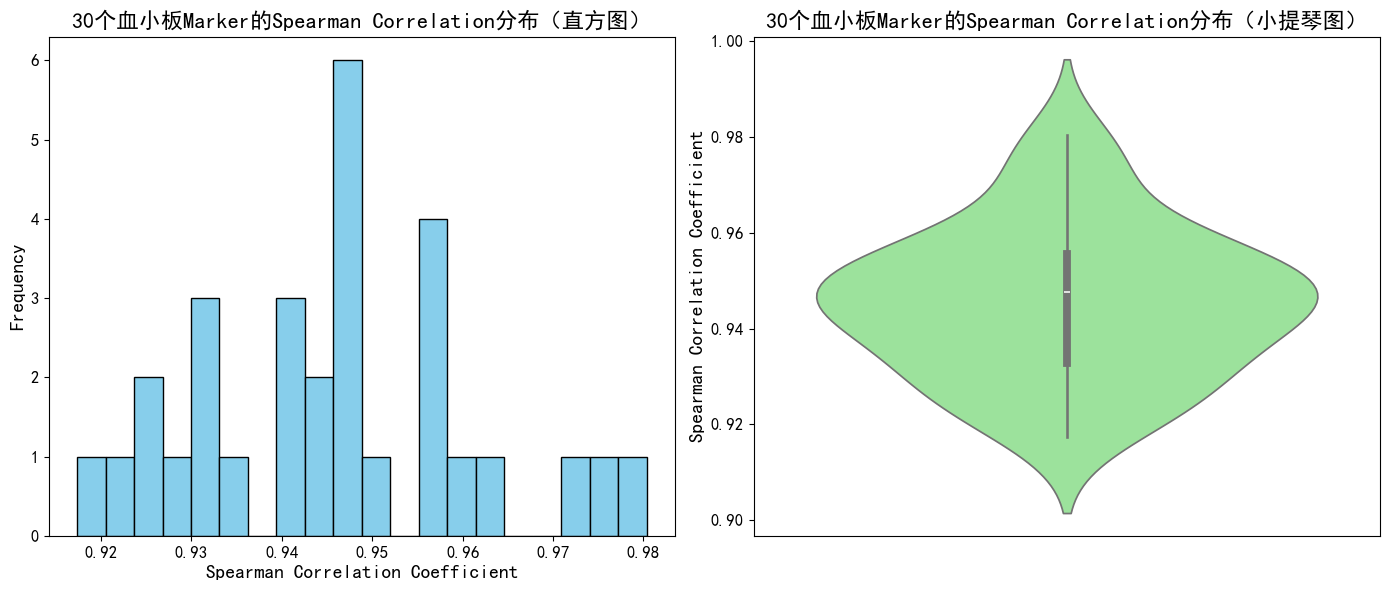

In [12]:
# 创建一个图形和子图
plt.figure(figsize=(14, 6))

# 左侧子图：直方图
plt.subplot(1, 2, 1)
plt.hist(platelet_30_markers['Spearman_Correlation'], bins=20, color='skyblue', edgecolor='black')
plt.title('30个血小板Marker的Spearman Correlation分布（直方图）', fontsize=16)
plt.xlabel('Spearman Correlation Coefficient', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.grid(True)

# 右侧子图：小提琴图
plt.subplot(1, 2, 2)
sns.violinplot(y=platelet_30_markers['Spearman_Correlation'], color='lightgreen')
plt.title('30个血小板Marker的Spearman Correlation分布（小提琴图）', fontsize=16)
plt.ylabel('Spearman Correlation Coefficient', fontsize=14)
plt.tick_params(axis='x', bottom=False, top=False, labelbottom=False)
plt.yticks(fontsize=12)
#plt.grid(True)

# 调整子图之间的间距
plt.tight_layout()
plt.savefig(r'F:\工作\流程开发\血浆样本污染\文章\代码整理\figures\fig4\4e.1.1-30个血小板Marker的Spearman Correlation分布.pdf', bbox_inches='tight')



Figure 4e: 1-30个血小板Marker的Spearman Correlation分布.pdf

In [13]:
platelet_spearman_marker_list = list(platelet_30_markers['Protein'].str.split("_").str.get(1))

mann_platelet_marker = pd.read_excel("F:\工作\流程开发\血浆样本污染\Quality-Control-of-the-Plasma-Proteome-master\data\Marker List.xlsx",sheet_name="Platelets")
platelet_mann_marker_list = list(mann_platelet_marker['Gene names'])
platelet_mann_marker_list = [item for sublist in (item.split(';') for item in platelet_mann_marker_list) for item in sublist]


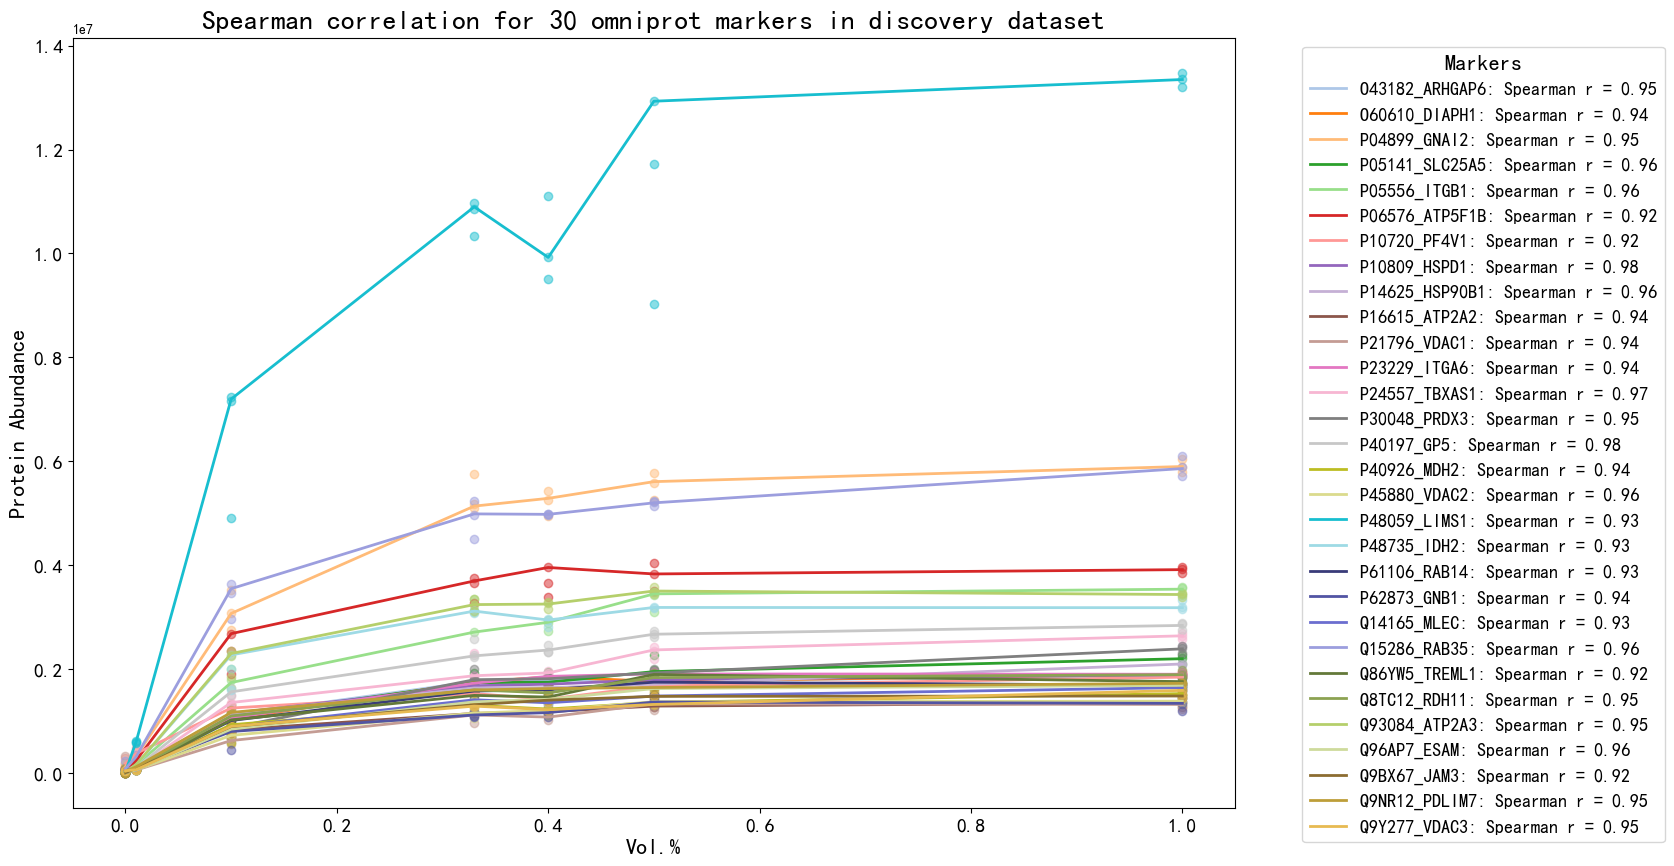

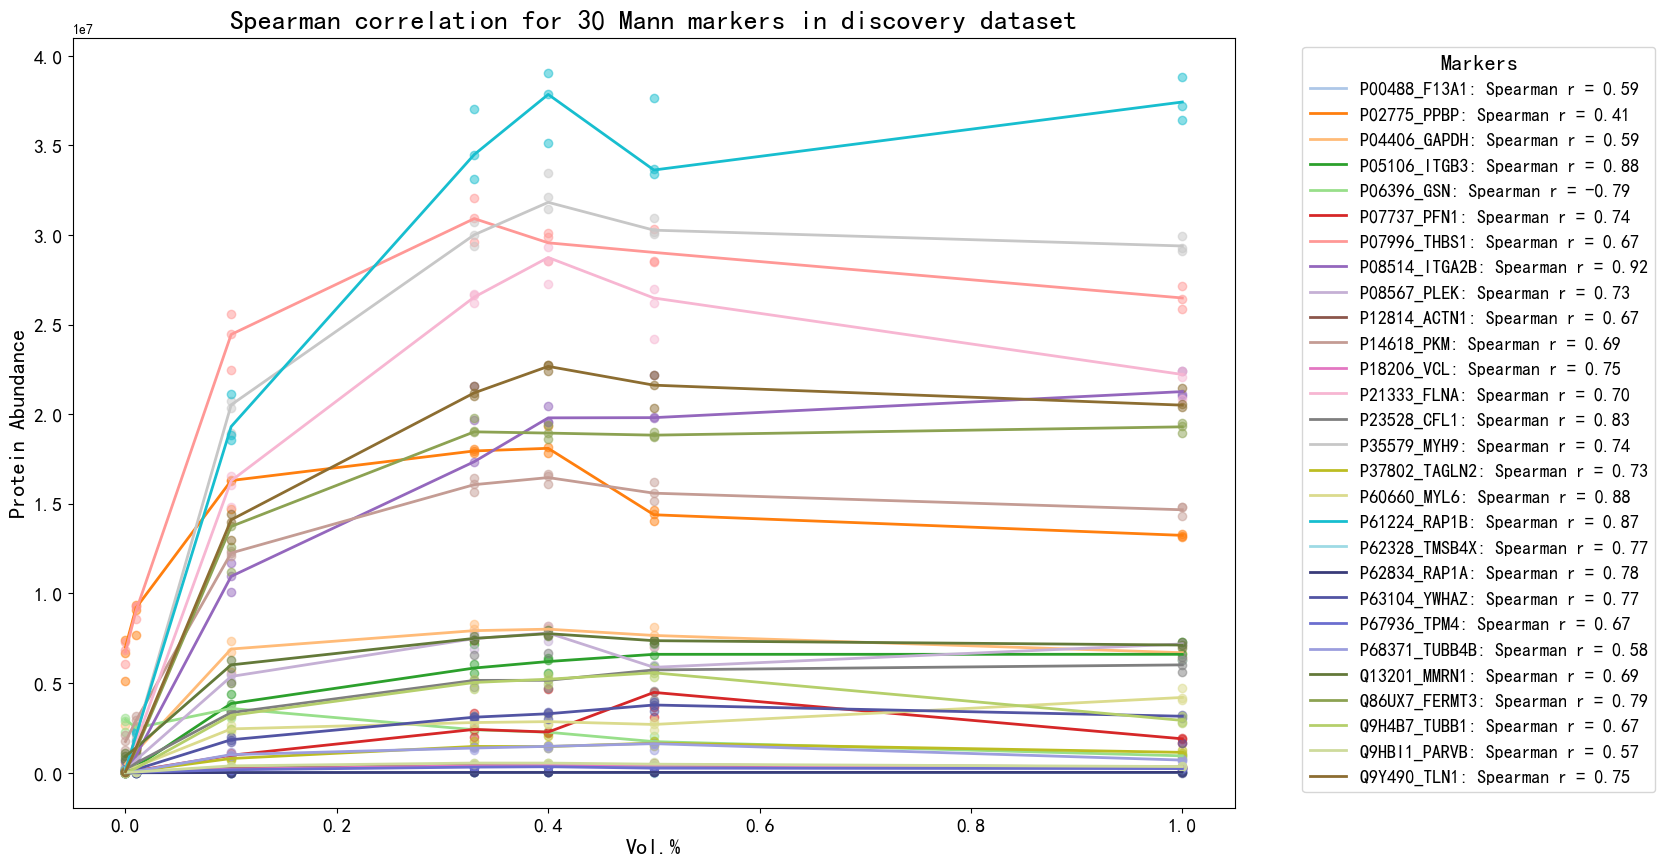

In [17]:
def plot_markers(tmp, marker_list, title,n):
    tmp = tmp[tmp['Genes'].isin(marker_list)]
    tmp = tmp.iloc[:, 5:]
    tmp = tmp.T
    tmp['Sample_ID'] = tmp.index
    tmp = pd.merge(discovery_sampleinfo, tmp, on='Sample_ID')

    # 获取颜色循环
    colors1 = plt.cm.tab20.colors  # 20种颜色
    colors2 = plt.cm.tab20b.colors  # 另外20种颜色
    colors = np.concatenate((colors1, colors2))  # 合并成30种颜色

    # 创建图形和轴
    plt.figure(figsize=(15, 10))

    # 遍历每一列并绘制散点图和lowess曲线
    for i, col in enumerate(tmp.columns[-n:]):
        x = tmp['Vol.%']
        y = tmp[col]
        
        # 计算Spearman相关系数
        corr, _ = spearmanr(x, y)
        
        # 使用lowess进行平滑
        z = lowess(y, x, frac=0.2)
        
        # 绘制散点图，不显示在图例中
        plt.scatter(x, y, alpha=0.5, color=colors[i+1], label='')  # 设置label为空字符串
        
        # 绘制lowess曲线，并添加Spearman相关系数到label
        plt.plot(z[:, 0], z[:, 1], label=f'{col}: Spearman r = {corr:.2f}', linewidth=2, color=colors[i+1])

    # 设置标题和标签
    plt.title(title, fontsize=20)
    plt.xlabel('Vol.%', fontsize=16)
    plt.ylabel('Protein Abundance', fontsize=16)
    plt.legend(title='Markers', bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize=16, fontsize=13)
    plt.tick_params(axis='both', which='major', labelsize=14)

    # 保存当前图形到PdfPages对象
    pdf.savefig(bbox_inches='tight')
    plt.show()
    plt.close()

# 数据准备
tmp = platelet_discovery_matrix
marker_list1 = platelet_spearman_marker_list
marker_list2 = platelet_mann_marker_list

# 创建PdfPages对象
with PdfPages(r'F:\工作\流程开发\血浆样本污染\文章\代码整理\figures\fig4\4e.2.4-血小板marker在验证队列的spearman correlation折线图.pdf') as pdf:
    # 绘制第一张图
    plot_markers(tmp, marker_list1, 'Spearman correlation for 30 omniprot markers in discovery dataset',n=30)
    
    # 绘制第二张图
    plot_markers(tmp, marker_list2, 'Spearman correlation for 30 Mann markers in discovery dataset',n=28)

Figure 4d: Platelets_spearman_10%_30markers_abundance_distribution20250211.pdf

In [19]:
exp_mt = pd.read_csv(r"F:\工作\流程开发\血浆样本污染\MarkerFinding\data_ghh\01血小板污染\Platelet_different_ratio_evaluation_np23_21samples20241118.pg_matrix.tsv",sep = "\t")
n = 5

new_columns = exp_mt.columns[:n].tolist()
for col in exp_mt.columns[n:]:
    # 用“\”分隔，保留最后一个元素
    last_element = col.split('\\')[-1]
    # 用“.”分隔，保留第一个元素
    new_col = last_element.split('.')[0]
    new_col = new_col.split('_')[-1]
    new_columns.append(new_col)

# 修改df的列名
exp_mt.columns = new_columns

# 去除单个肽段对应到多个蛋白上的蛋白组
exp_mt = exp_mt[~exp_mt['Protein.Group'].str.contains(';')] ## comment this while doing bar chart

# 移除缺失率大于50%的行（不包括前五列）
missing_rate = exp_mt.iloc[:, n:].isnull().mean(axis=1)
exp_mt = exp_mt[missing_rate < 0.5]  ## comment this while doing bar chart
        
# exp_mt = exp_mt.dropna(subset=exp_mt.columns[5:], how='all').fillna(0)      
exp_mt.index = exp_mt['Protein.Group'].astype(str) + "_" + exp_mt['Genes'].astype(str)
exp_mt.index.name = None

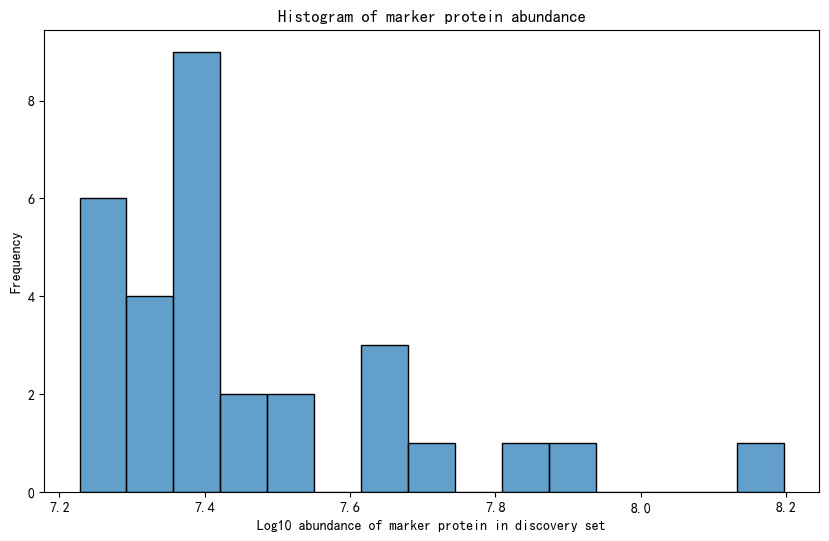

In [20]:
spearman_10_marker = pd.read_csv(r'F:\工作\流程开发\血浆样本污染\MarkerFinding\建立血小板等污染相关的算法-Task5_20250120\results\markers\spearman_10%.csv')
exp_mt_marker = exp_mt[exp_mt.index.isin(spearman_10_marker['Protein'])]
exp_mt_marker['abundance'] = exp_mt_marker.iloc[:, 5:].sum(axis=1)
exp_mt_marker['log10_abundance'] = np.log10(exp_mt_marker['abundance'])

plt.figure(figsize=(10, 6))
ax = sns.histplot(exp_mt_marker['log10_abundance'], bins=15, edgecolor='black', alpha=0.7, kde=False)


plt.title('Histogram of marker protein abundance')
plt.xlabel('Log10 abundance of marker protein in discovery set')
plt.ylabel('Frequency')

with PdfPages(r'F:\工作\流程开发\血浆样本污染\文章\代码整理\figures\fig4\4d.Platelets_spearman_10%_30markers_abundance_distribution20250211.pdf') as pdf:
    pdf.savefig()
    #plt.close()

plt.show()

Figure 4g: Platelets_spearman_10%_30markers_prot_abundance_distribution_mean20250211_deleteLowIntensity.pdf

In [23]:
pg_matrix_np23_132 = pd.read_csv(r"F:\工作\流程开发\血浆样本污染\MarkerFinding\建立血小板等污染相关的算法-Task5_20250120\Platelets_serial_dilution\OmniProtV2_platelets250113_con_index_24minDIA_report.pg_matrix.tsv",sep = "\t")
sampleinfo_132 = pd.read_excel(r"F:\工作\流程开发\血浆样本污染\MarkerFinding\建立血小板等污染相关的算法-Task5_20250120\Platelets_serial_dilution\OmniProtV2_Platelet_index_sample_information20250115-0906.xlsx")

pg_matrix_np23_132= process_and_modify_platelet(pg_matrix_np23_132)
pg_matrix_np23_132_spearman_10_markers = pg_matrix_np23_132[pg_matrix_np23_132.index.isin(spearman_10_marker['Protein'])].iloc[:, 5:].T
pg_matrix_np23_132_spearman_10_markers['Sample_ID'] = pg_matrix_np23_132_spearman_10_markers.index.astype(str)

sampleinfo_132['Sample_ID'] = sampleinfo_132['Sample_ID'].astype(str).str.zfill(3)
sampleinfo_132 = sampleinfo_132[(sampleinfo_132['Concentration_ID']!='P00') & (~sampleinfo_132['Sample_ID'].isin(['017', '024', '131']))]

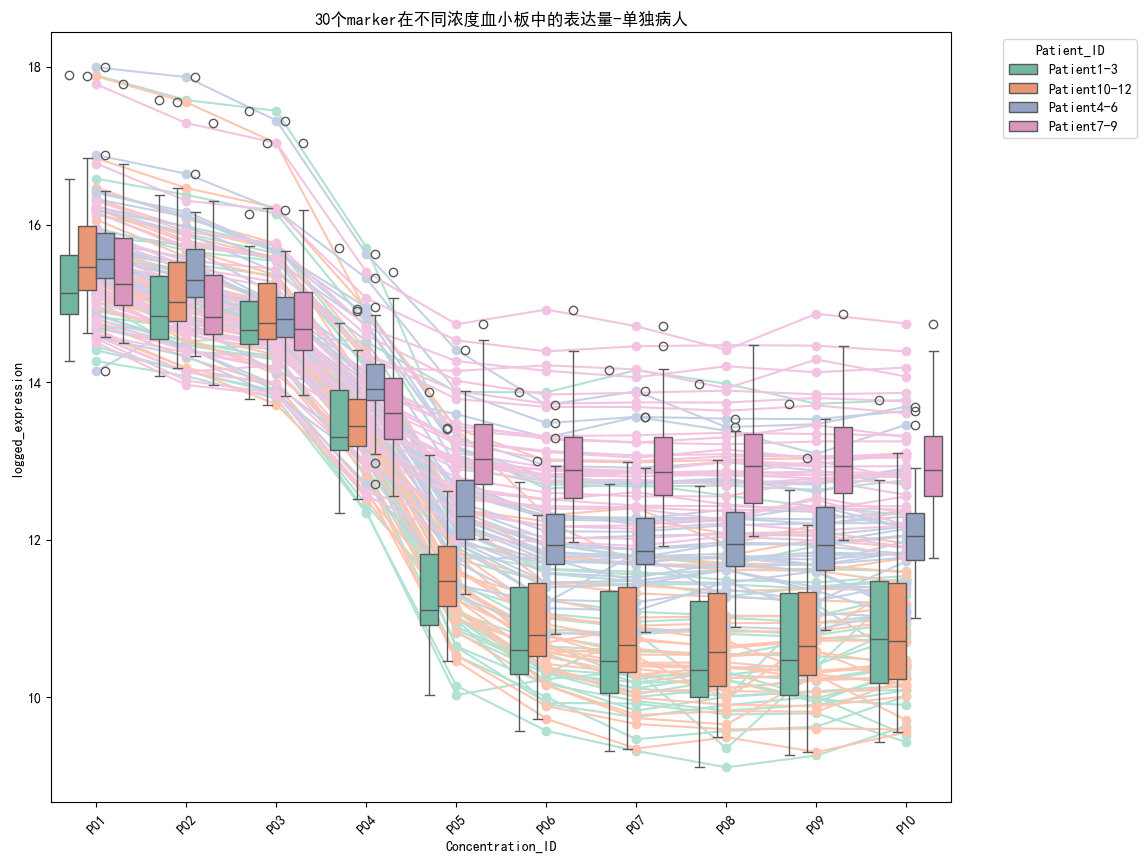

In [24]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    try:
        c = mcolors.to_rgba(color)
    except ValueError:
        return color
    return tuple(min(1, max(0, c[i] + (1 - c[i]) * amount)) for i in range(3)) + (c[3],)

def plot_boxplot_with_median_lines(pg_matrix, sampleinfo, title):
    # 合并数据框
    merged_df = pd.merge(pg_matrix, sampleinfo[['Sample_ID', 'Concentration_ID', 'Patient_ID']], on='Sample_ID')

    # 选择数值列
    numeric_cols = merged_df.select_dtypes(include=[np.number]).columns

    # 按 Concentration_ID 和 Patient_ID 分组并计算平均值
    grouped_avg = merged_df.groupby(['Concentration_ID', 'Patient_ID'])[numeric_cols].mean().reset_index()

    # 将数据转换为长格式
    grouped_avg_long = grouped_avg.melt(id_vars=['Concentration_ID', 'Patient_ID'], var_name='Protein', value_name='Value')

    # 绘制 boxplot
    plt.figure(figsize=(15, 10))

    # 使用 hue 参数按 Patient_ID 分组
    
    # 计算每个 Protein 在不同 Concentration_ID 之间的中位数
    median_df = grouped_avg_long.groupby(['Patient_ID', 'Protein', 'Concentration_ID'])['Value'].median().unstack()

    # 获取唯一的 Patient_ID 列表
    patient_ids = median_df.index.get_level_values('Patient_ID').unique()

    # 创建一个颜色映射
    color_map = {patient: lighten_color(color, 0.5) for patient, color in zip(patient_ids, plt.cm.Set2.colors)}

    # 连接相同 Patient_ID 和 Protein 的中位数
    for (patient, protein), group in median_df.iterrows():
        plt.plot(group.index, group.values, marker='o', linestyle='-', color=color_map[patient])
    sns.boxplot(x='Concentration_ID', y='Value', hue='Patient_ID', data=grouped_avg_long, palette='Set2')

    plt.xticks(rotation=45)
    plt.xlabel('Concentration_ID')
    plt.ylabel('logged_expression')
    plt.title('30个marker在不同浓度血小板中的表达量-单独病人')
    
    # 调整边距以确保图例完整显示
    plt.subplots_adjust(right=0.75, left=0.15)
    
    plt.legend(title='Patient_ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig(rf'{title}.pdf', format='pdf')
    plt.show()

# 示例调用
pg_matrix_np23_132_spearman_10_markers_markers_logged = np.log(pg_matrix_np23_132_spearman_10_markers.astype(float) + 1e-6)
pg_matrix_np23_132_spearman_10_markers_markers_logged['Sample_ID'] = pg_matrix_np23_132_spearman_10_markers_markers_logged.index.astype(str)
## na填充低表达量
pg_matrix_np23_132_spearman_10_markers_markers_logged.iloc[:, :-1] = pg_matrix_np23_132_spearman_10_markers_markers_logged.iloc[:, :-1].where(pg_matrix_np23_132_spearman_10_markers.iloc[:, :-1] >= np.log(10000), np.nan)

plot_boxplot_with_median_lines(pg_matrix_np23_132_spearman_10_markers_markers_logged, sampleinfo_132, r'F:\工作\流程开发\血浆样本污染\文章\代码整理\figures\fig4\4g.Platelets_spearman_10%_30markers_prot_abundance_distribution_mean20250211_deleteLowIntensity')

Figure 4h:Platelets_spearman_10%_30markers_con_index_spearman_all20250211.pdf

In [27]:
def plot_correlations_to_pdf(matrix, col1, col2, title, filename, plots=['pearson', 'spearman', 'spline']):
    # 计算污染指数
    filtered_tmp = matrix

    # 创建PDF文件
    with PdfPages(filename) as pdf:
        results = []

        if 'pearson' in plots:
            # Pearson 相关系数
            pearson_corr, pval_pearson = pearsonr(filtered_tmp[col1].astype(float), filtered_tmp[col2].astype(float))
            #print(f'Pearson Correlation: {pearson_corr}, p-value: {pval_pearson}')

            # 绘制散点图并添加最佳拟合线
            plt.figure(figsize=(10, 6))
            sns.scatterplot(x=col1, y=col2, data=filtered_tmp)
            sns.regplot(x=col1, y=col2, data=filtered_tmp, scatter=False, ci=None, line_kws={'color': 'red', 'linestyle': '--'})

            # 添加相关系数和 p 值到图中
            plt.title(f'{title}\nPearson Correlation: {pearson_corr:.2f}, p-value: {pval_pearson:.2e}')
            plt.xlabel(col1)
            plt.ylabel(col2)
            pdf.savefig()  # 保存当前图到PDF
            plt.close()

            results.append({'Method': 'Pearson', 'Correlation': pearson_corr, 'P-value': pval_pearson})

        if 'spearman' in plots:
            # Spearman 相关系数
            spearman_corr, pval_spearman = spearmanr(filtered_tmp[col1], filtered_tmp[col2])
            #print(f'Spearman Correlation: {spearman_corr}, p-value: {pval_spearman}')

            # 绘制散点图并添加 LOWESS 拟合曲线
            plt.figure(figsize=(10, 6))
            sns.scatterplot(x=col1, y=col2, data=filtered_tmp)

            # 使用 LOWESS 进行拟合
            lowess_result = lowess(filtered_tmp[col2], filtered_tmp[col1], frac=0.2)
            plt.plot(lowess_result[:, 0], lowess_result[:, 1], color='green', linestyle='--')

            # 添加相关系数和 p 值到图中
            plt.title(f'{title}\nSpearman Correlation: {spearman_corr:.2f}, p-value: {pval_spearman:.2e}')
            plt.xlabel(col1)
            plt.ylabel(col2)
            pdf.savefig()  # 保存当前图到PDF
            plt.close()

            results.append({'Method': 'Spearman', 'Correlation': spearman_corr, 'P-value': pval_spearman})

        if 'spline' in plots:
            # Spline Regression
            plt.figure(figsize=(10, 6))
            sns.scatterplot(x=col1, y=col2, data=filtered_tmp)

            # 确保 x 值是递增的
            x = filtered_tmp[col1].values
            y = filtered_tmp[col2].values
            sorted_indices = np.argsort(x)
            x_sorted = x[sorted_indices]
            y_sorted = y[sorted_indices]
            unique_x = np.unique(x_sorted)
            mean_y = np.array([y_sorted[x_sorted == ux].mean() for ux in unique_x])

            # 使用 Spline 进行拟合
            spline = UnivariateSpline(unique_x, mean_y, k=3, s=1000)  # k=3 表示三次样条，s 是平滑因子
            x_new = np.linspace(x_sorted.min(), x_sorted.max(), 300)
            y_new = spline(x_new)
            plt.plot(x_new, y_new, color='blue', linestyle='--')

            # 计算 R squared
            ss_res = np.sum((y_sorted - spline(x_sorted))**2)
            ss_tot = np.sum((y_sorted - np.mean(y_sorted))**2)
            r_squared = 1 - (ss_res / ss_tot)

            # 添加相关系数和 p 值到图中
            plt.title(f'{title}\nSpline Regression\nR squared: {r_squared:.2f}')
            plt.xlabel(col1)
            plt.ylabel(col2)
            pdf.savefig()  # 保存当前图到PDF
            plt.close()
   
            results.append({'Method': 'Spline', 'Correlation': r_squared, 'P-value': None})

    # 创建结果数据框
    results_df = pd.DataFrame(results)
    
    return results_df

def containmination_index(marker,pro):
    marker_pro = pro[pro.index.isin(marker)]

    marker_exp = marker_pro.sum(axis=0)
    total_exp = pro.sum(axis=0)
    res = pd.DataFrame(marker_exp/total_exp)
    res.columns = ['containmination_index']
    res['Sample_ID'] = res.index
    return res

spearman10_comtainmination_index = containmination_index(spearman_10_marker['Protein'],pg_matrix_np23_132.iloc[:,5:])
tmp = pd.merge(sampleinfo_132,spearman10_comtainmination_index,on = 'Sample_ID' )
tmp['log10_platelet_count'] = np.log10(tmp['Platelet_absolute amount (calculation)'])

print(plot_correlations_to_pdf(tmp, 'log10_platelet_count', 'containmination_index', 
                        f'Correlations between log10(platelet count) and spearman markers', 
                        fr'F:\工作\流程开发\血浆样本污染\文章\代码整理\figures\fig4\4h.1.Platelets_spearman_10%_30markers_con_index_spearman_all20250211.pdf'))



     Method  Correlation       P-value
0   Pearson     0.749085  2.677146e-22
1  Spearman     0.811212  1.450044e-28
2    Spline     0.926972           NaN


Figure 4h: Platelets_spearman_10%_30markers_con_index_pearson_partial20250211.pdf

In [28]:
tmp = tmp[tmp['log10_platelet_count'] >= 6.2]
print(plot_correlations_to_pdf(tmp, 'log10_platelet_count', 'containmination_index', 
                        f'Correlations between log10(platelet count) and spearman markers', 
                        fr'F:\工作\流程开发\血浆样本污染\文章\代码整理\figures\fig4\4h.2.Platelets_spearman_10%_30markers_con_index_pearson_partial20250211.pdf'))

     Method  Correlation       P-value
0   Pearson     0.935452  6.362088e-17
1  Spearman     0.937262  3.978009e-17
2    Spline     0.949945           NaN


Figure 4j: Platelets_30markers_10patients_PRP_PPP_contamination_index_boxplot20250120.pdf

In [ ]:
pg_matrix_10patients = pd.read_csv(r'F:\工作\流程开发\血浆样本污染\MarkerFinding\建立血小板等污染相关的算法-Task5_20250120\Platelets_serial_dilution_application_10Patients_PRP_PPP\ot_treated_report20241024WAN20241021gaohh_OmniprotV2_contamination_OmniPr.gg_matrix.pg_matrix.tsv',sep = "\t")
sampleinfo_10patients = pd.read_excel(r'F:\工作\流程开发\血浆样本污染\MarkerFinding\建立血小板等污染相关的算法-Task5_20250120\Platelets_serial_dilution_application_10Patients_PRP_PPP\10Patients_PRP_PPP_sample_information20241027.xlsx')

pg_matrix_10patients = process_and_modify_platelet(pg_matrix_10patients)
sampleinfo_10patients['Sample_ID'] = sampleinfo_10patients['Sample_ID'].astype(str).str.zfill(3)

pg_matrix_10patients_marker = pg_matrix_10patients[pg_matrix_10patients.index.isin(spearman_10_marker['Protein'])]
sampleinfo_10patients = sampleinfo_10patients[sampleinfo_10patients['Plasma_type'].isin(['PRP','PPP'])]
sampleinfo_10patients = sampleinfo_10patients[sampleinfo_10patients['NP_ID']=='NP23']


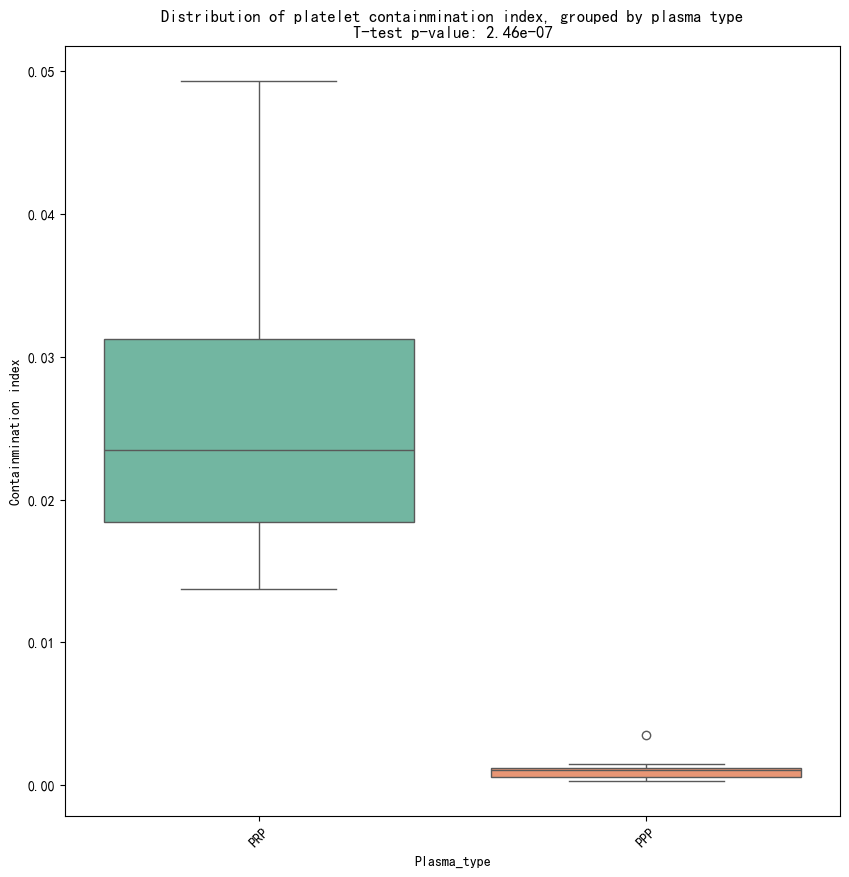

In [33]:
spearman10_10patients_comtainmination_index = containmination_index(spearman_10_marker['Protein'],pg_matrix_10patients.iloc[:,5:])
merged_df = pd.merge(spearman10_10patients_comtainmination_index, sampleinfo_10patients, left_on='Sample_ID', right_on='Sample_ID').set_index('Sample_ID')
plt.figure(figsize=(10, 10))

# 绘制分组 boxplot，使用 hue 参数区分不同的 Plasma_type
sns.boxplot(x='Plasma_type', y='containmination_index', data=merged_df, hue='Plasma_type', palette='Set2')

# 计算 t-test p 值
prp_values = merged_df[merged_df['Plasma_type'] == 'PRP']['containmination_index']
ppp_values = merged_df[merged_df['Plasma_type'] == 'PPP']['containmination_index']
t_stat, p_val = ttest_ind(prp_values, ppp_values, nan_policy='omit')

plt.xticks(rotation=45)
plt.xlabel('Plasma_type')
plt.ylabel(f'Containmination index')
plt.title(f'Distribution of platelet containmination index, grouped by plasma type\nT-test p-value: {p_val:.2e}')

with PdfPages(r'F:\工作\流程开发\血浆样本污染\文章\代码整理\figures\fig4\4j.Platelets_30markers_10patients_PRP_PPP_contamination_index_boxplot20250120.pdf') as pdf:
    pdf.savefig()

plt.show()

Figure 4k: 2-NP74.1_30marker_spearman_r_distribution.pdf

In [35]:
pg_matrix_bu = pd.read_csv(r'F:\工作\流程开发\血浆样本污染\MarkerFinding\Task9_20250313\不同NP81_NP74处理血小板样本_task200250324\WAN20250321gaohh_OmniProtV2_24minDIA_report.pg_matrix.tsv',sep = '\t')
pg_matrix_bu = process_and_modify_platelet(pg_matrix_bu)
platelet_marker = ["P48059", "P04899", "Q15286", "P06576", "Q93084", "P05556", "P48735", "P40197", "P24557", "P05141", "P30048", "P14625", "P23229", "O60610", "O43182", "P10809", "P10720", "Q8TC12", "Q9NR12", "P61106", "Q86YW5", "Q96AP7", "Q14165", "Q9BX67", "Q9Y277", "P40926", "P45880", "P16615", "P62873", "P21796"]

sampleinfo_bu = pd.read_excel(r'F:\工作\流程开发\血浆样本污染\MarkerFinding\Task9_20250313\不同NP81_NP74处理血小板样本_task200250324\Sample_information20250324-1500.xlsx')
sampleinfo_bu['Sample_ID'] = sampleinfo_bu['Sample_ID'].astype(str)


In [37]:
def group_median_normalize(X, group_col, exclude_cols=None):
    # X为DataFrame，需包含分组列和蛋白表达数据
    if exclude_cols is None:
        exclude_cols = []
    
    groups = X[group_col].unique()
    group_medians = {}
    
    # 计算每个组的参考中位数
    for group in groups:
        group_data = X[X[group_col] == group].drop(columns=[group_col] + exclude_cols)
        sample_medians = group_data.median(axis=0)
        group_medians[group] = np.median(sample_medians)
    
    X_norm = X.copy()
    
    # 标准化每个组的数据
    for group in group_medians:
        group_idx = X_norm[X_norm[group_col] == group].index
        group_data = X_norm.loc[group_idx].drop(columns=[group_col] + exclude_cols)
        ref_median = group_medians[group]
        sample_medians = group_data.median(axis=0)
        sample_medians = sample_medians.replace(0, 1)
        scaling_factors = ref_median / sample_medians
        X_norm.loc[group_idx, group_data.columns] = group_data * scaling_factors
    
    return X_norm


In [40]:
tmp = pg_matrix_bu[pg_matrix_bu['Protein.Group'].isin(platelet_marker)].T
tmp = pd.merge(tmp,sampleinfo_bu[['Sample_ID','Condition_ID','Platelet_con']],left_index=True,right_on='Sample_ID')

tmp1 = tmp[tmp['Sample_ID'].isin(sampleinfo_bu[sampleinfo_bu['NP_ID']=='NP74']['Sample_ID'].astype(str).tolist())]

tmp1 = group_median_normalize(tmp1, 'Condition_ID', exclude_cols=['Sample_ID', 'Platelet_con'])
correlation_results = pd.DataFrame(columns=['Column1', 'Column2', 'Spearman_r', 'P_value'])

col1 = tmp1.columns[-1]

for col2 in tmp1.columns[:30]:
        # 计算 Spearman 相关系数和 p 值
        r, p = spearmanr(tmp1[col1], tmp1[col2])
        
        # 将结果存储在 correlation_results 中
        new_row = pd.DataFrame({
            'Column1': [col1],
            'Column2': [col2],
            'Spearman_r': [r],
            'P_value': [p]
        })
        correlation_results = pd.concat([correlation_results, new_row], ignore_index=True)


plt.figure(figsize=(10, 6))
plt.hist(correlation_results['Spearman_r'], edgecolor='black')
plt.title('30个血小板marker蛋白在NP74样本中的Spearman r分布')
plt.xlabel('Spearman_r')
plt.ylabel('Frequency')

# 保存到 PDF 文件
plt.savefig(r'F:\工作\流程开发\血浆样本污染\文章\代码整理\figures\fig4\4k.2.1-NP74.1_30marker_spearman_r_distribution.pdf', format='pdf')
plt.close()

Figure 4i: 3-NP74_platelet_containmination_index.pdf

In [57]:
def contamination_index(marker,pro,reverse = False):
    pattern = '|'.join(re.escape(m) for m in marker)
    marker_pro = pro[pro.index.str.contains(pattern)]

    marker_exp = marker_pro.sum(axis=0)
    total_exp = pro.sum(axis=0)
    if(reverse ==True):
        res = pd.DataFrame(total_exp/marker_exp)
    else:
        res = pd.DataFrame(marker_exp/total_exp)

    res.columns = ['contamination_index']
    res['Sample_ID'] = res.index

    return res[['Sample_ID','contamination_index']].sort_values(by = 'Sample_ID')

def plot_dataframe(df, sample_ids,outfile_prefix, title='',width = 1):
     ## 20个样本，需要宽度为6画出来好看，根绝样本量调节宽度
    plt.figure(figsize=(width*6, 5))

    # 绘制柱状图
    ax = sns.barplot(x=df.index, y='contamination_index', data=df.reset_index())
    
    # 添加平均值和标准差的水平线
    mean_value = df['contamination_index'].mean()
    #std_dev = df['contamination_index'].std()
    ax.axhline(y=mean_value, color='red', linestyle='--', label=f'Mean contamination index: {mean_value:.5f}')
    
    # 设置标题和标签
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('Contamination Index')
    ax.legend()
    
    # 显示图形
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.xticks(ticks=range(len(sample_ids)), labels=sample_ids, rotation=45, fontsize=12) 

    plt.savefig(outfile_prefix + ".pdf", format='pdf', bbox_inches='tight')

    plt.show()

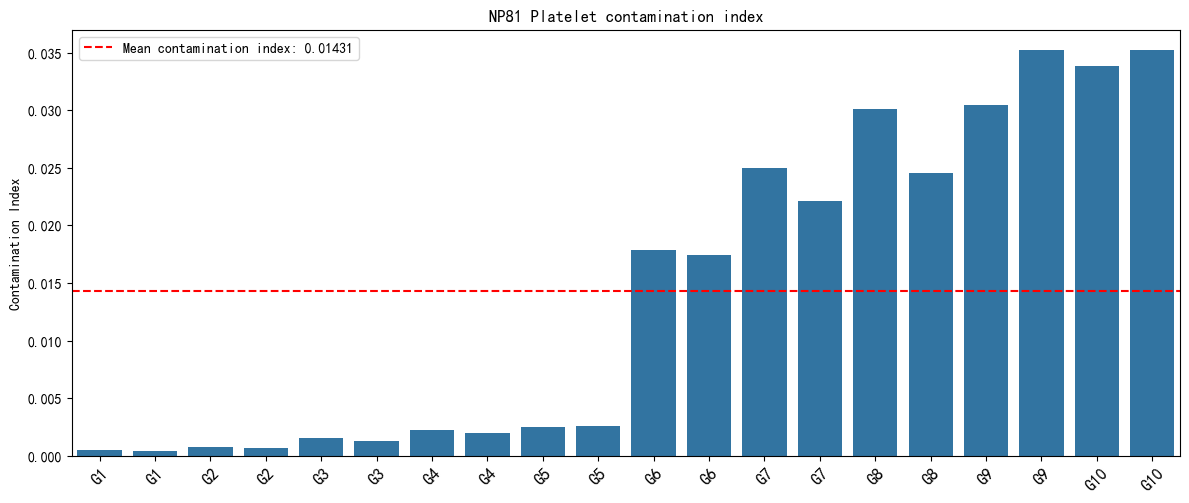

In [59]:
tmp = pg_matrix_bu
tmp.index= tmp['Protein.Group']
tmp = tmp[sampleinfo_bu[sampleinfo_bu['NP_ID']=='NP74']['Sample_ID'].astype(str).tolist()]

platelet_contamination_index = contamination_index(platelet_marker,tmp)
#platelet_contamination_index['Sample_ID'] = platelet_contamination_index['Sample_ID'].astype(int)

platelet_contamination_index['Original_Sample_ID'] = platelet_contamination_index['Sample_ID']

# 创建 Sample_ID 到 NP_ID 的映射并替换
sample_id_to_np_id = dict(zip(sampleinfo_bu['Sample_ID'], sampleinfo_bu['Condition_ID']))
platelet_contamination_index['Sample_ID'] = platelet_contamination_index['Sample_ID'].map(sample_id_to_np_id)

sorted_index = index_natsorted(platelet_contamination_index['Sample_ID'])
platelet_contamination_index = platelet_contamination_index.iloc[sorted_index]

plot_dataframe(platelet_contamination_index,sample_ids = platelet_contamination_index['Sample_ID'].tolist(), outfile_prefix = r"F:\工作\流程开发\血浆样本污染\文章\代码整理\figures\fig4\4i.3-NP74_platelet_containmination_index", title='NP81 Platelet contamination index',width = len(sampleinfo_bu) / 20)


Figure 4m: 2-NP81.1_30marker_spearman_r_distribution.pdf

In [61]:
tmp = pg_matrix_bu[pg_matrix_bu['Protein.Group'].isin(platelet_marker)].T
tmp = pd.merge(tmp,sampleinfo_bu[['Sample_ID','Condition_ID','Platelet_con']],left_index=True,right_on='Sample_ID')

tmp1 = tmp[tmp['Sample_ID'].isin(sampleinfo_bu[sampleinfo_bu['NP_ID']=='NP81']['Sample_ID'].astype(str).tolist())]

tmp1 = group_median_normalize(tmp1, 'Condition_ID', exclude_cols=['Sample_ID', 'Platelet_con'])
correlation_results = pd.DataFrame(columns=['Column1', 'Column2', 'Spearman_r', 'P_value'])

col1 = tmp1.columns[-1]

for col2 in tmp1.columns[:30]:
        # 计算 Spearman 相关系数和 p 值
        r, p = spearmanr(tmp1[col1], tmp1[col2])
        
        # 将结果存储在 correlation_results 中
        new_row = pd.DataFrame({
            'Column1': [col1],
            'Column2': [col2],
            'Spearman_r': [r],
            'P_value': [p]
        })
        correlation_results = pd.concat([correlation_results, new_row], ignore_index=True)

plt.figure(figsize=(10, 6))
plt.hist(correlation_results['Spearman_r'], edgecolor='black')
plt.title('30个血小板marker蛋白在NP74样本中的Spearman r分布')
plt.xlabel('Spearman_r')
plt.ylabel('Frequency')

# 保存到 PDF 文件
plt.savefig(r'F:\工作\流程开发\血浆样本污染\文章\代码整理\figures\fig4\4m.2-NP81.1_30marker_spearman_r_distribution.pdf', format='pdf')
plt.close()

Figure 4n: 3-NP81_platelet_containmination_index.pdf

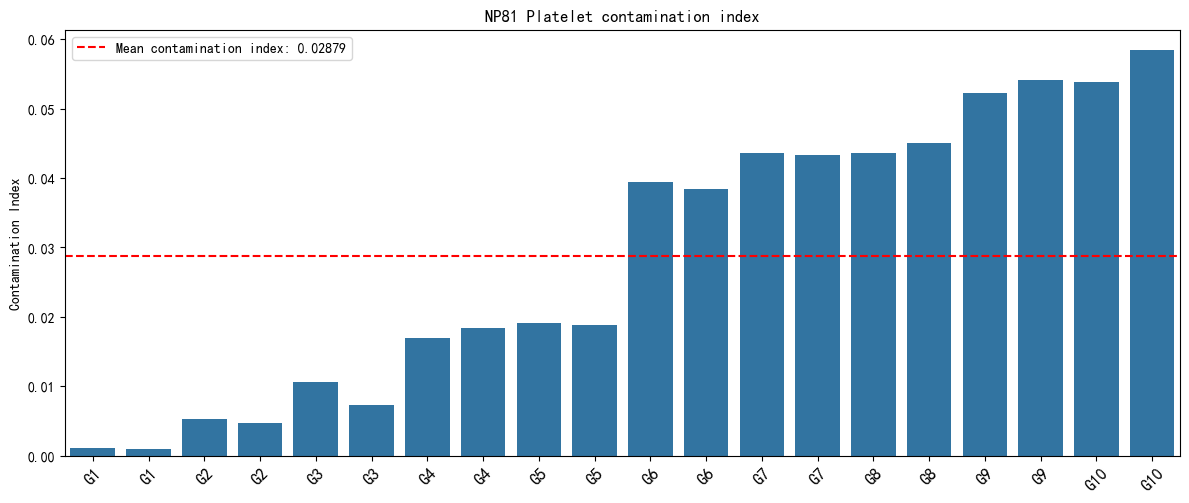

In [65]:
tmp = pg_matrix_bu
tmp.index= tmp['Protein.Group']
tmp = tmp[sampleinfo_bu[sampleinfo_bu['NP_ID']=='NP81']['Sample_ID'].astype(str).tolist()]

platelet_contamination_index = contamination_index(platelet_marker,tmp)
sample_id_to_np_id = dict(zip(sampleinfo_bu['Sample_ID'], sampleinfo_bu['Condition_ID']))
platelet_contamination_index['Sample_ID'] = platelet_contamination_index['Sample_ID'].map(sample_id_to_np_id)

sorted_index = index_natsorted(platelet_contamination_index['Sample_ID'])
platelet_contamination_index = platelet_contamination_index.iloc[sorted_index]
plot_dataframe(platelet_contamination_index,sample_ids = platelet_contamination_index['Sample_ID'].tolist(), outfile_prefix = r"F:\工作\流程开发\血浆样本污染\文章\代码整理\figures\fig4\4n.3-NP81_platelet_containmination_index", title='NP81 Platelet contamination index',width = len(sampleinfo_bu) / 20)


Figure 5d: 7b-红细胞marker在发现队列的spearman correlation折线图（logged abundace).pdf

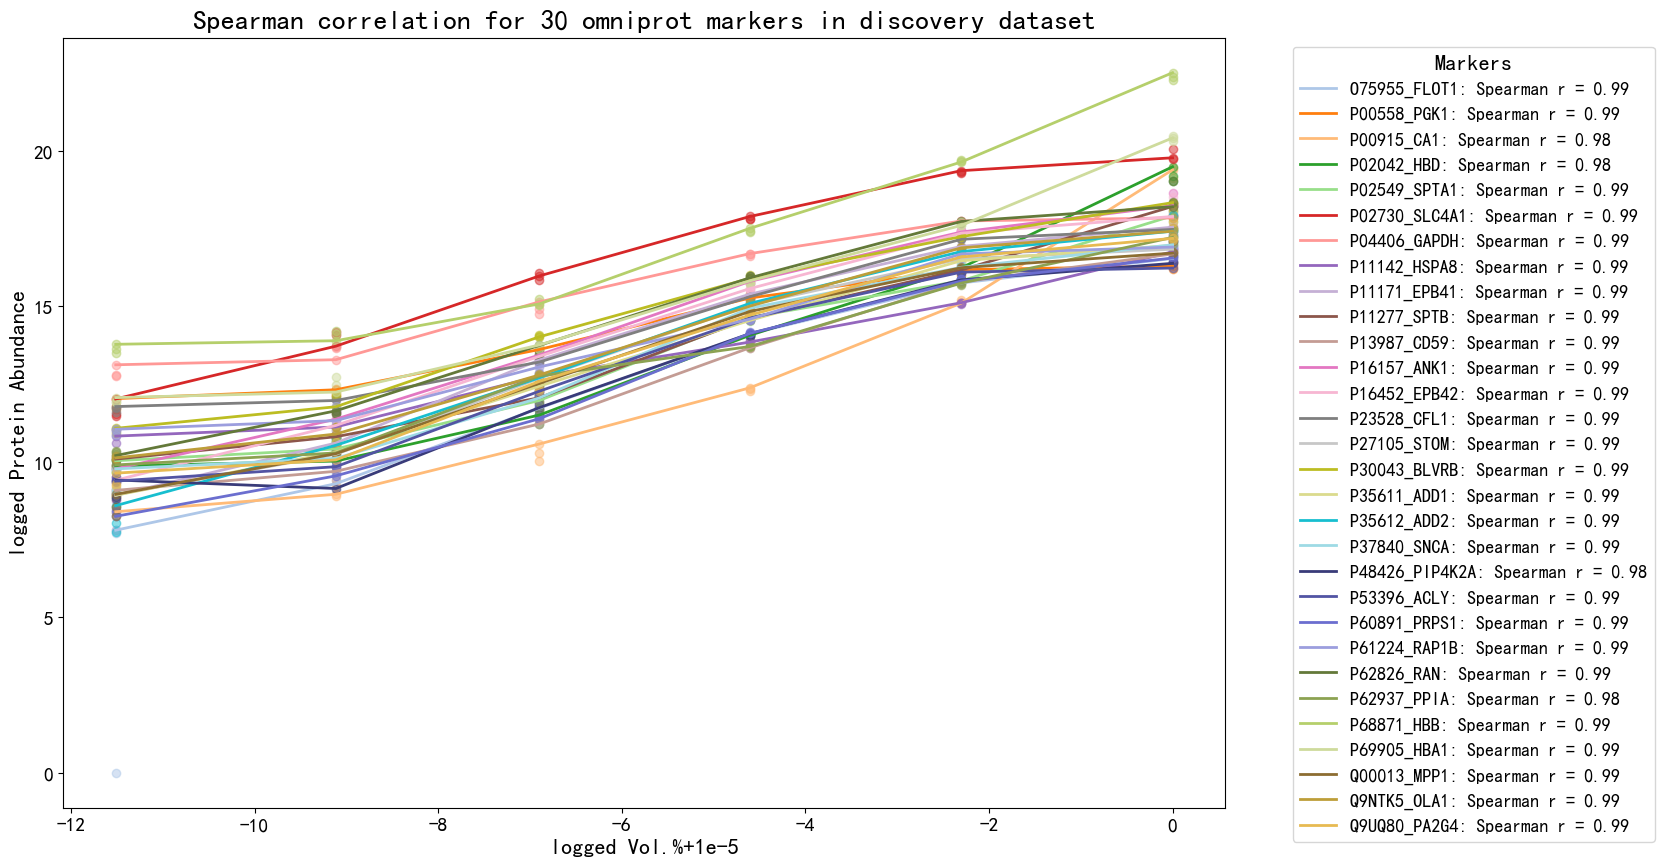

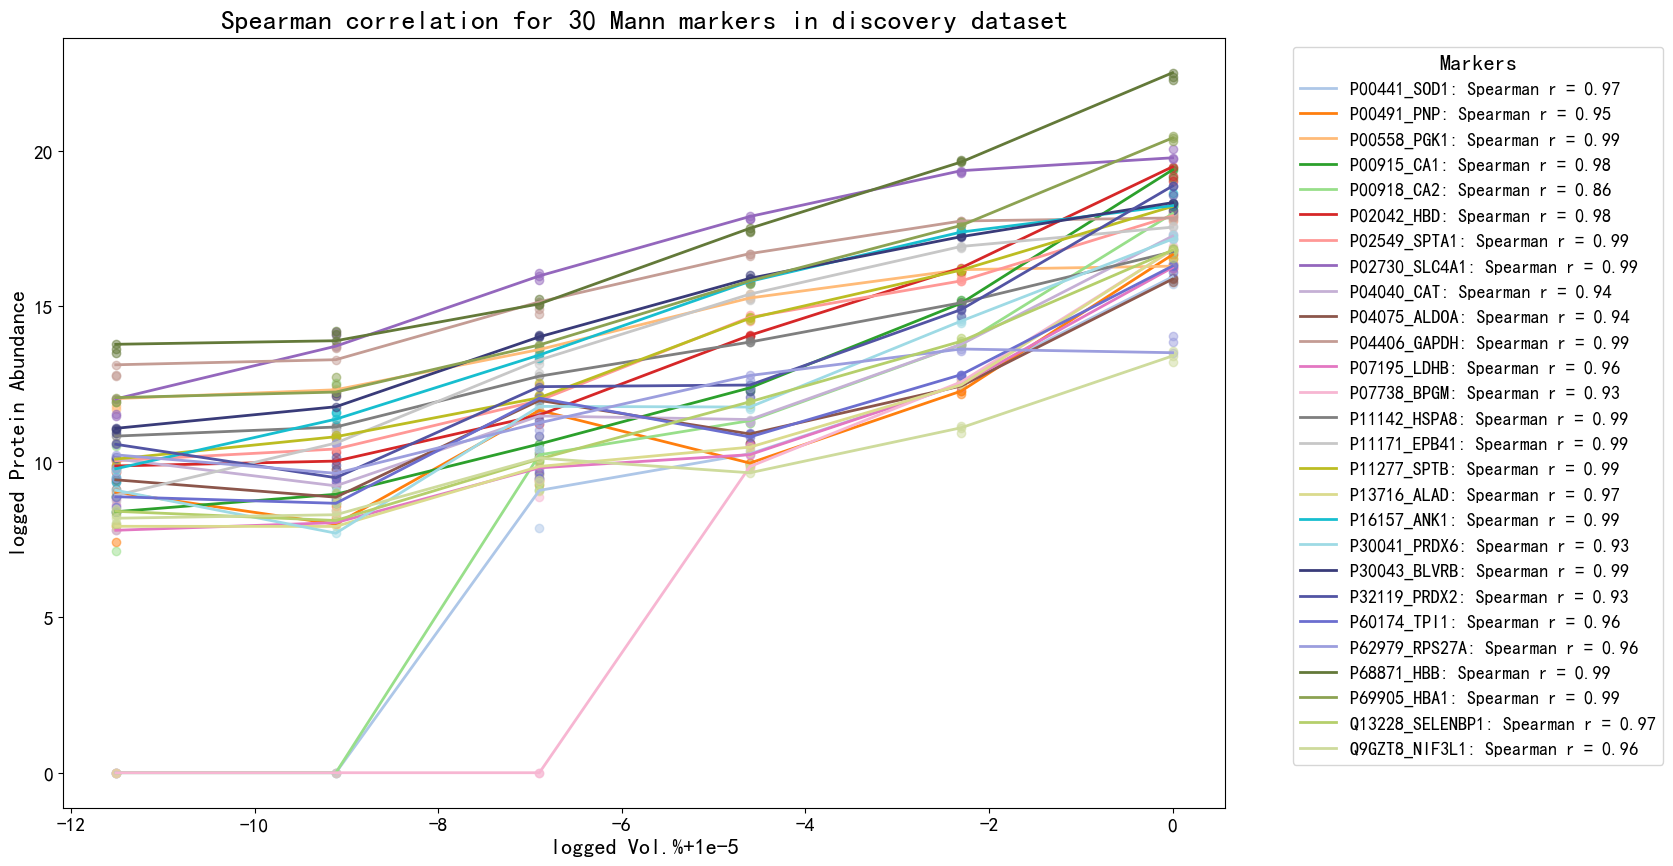

In [72]:
rbc_discovery_matrix = pd.read_csv(r'F:\工作\流程开发\血浆样本污染\MarkerFinding\data_ghh\02溶血污染\RBC_PRP_different_ratio_evaluation_NP23_21samples20241118.pg_matrix.tsv',sep = "\t")
rbc_discovery_matrix = process_and_modify_platelet(rbc_discovery_matrix)
rbc_30_markers = pd.read_csv(r"F:\工作\流程开发\血浆样本污染\MarkerFinding\建立血小板等污染相关的算法-Task7_20250217\results\discovery_30OmniprotMarker_ErythrocyteRatio_correlation\correlation_stats.csv")
rbc_30_markers = rbc_30_markers[rbc_30_markers['Method']=='Spearman']
rbc_spearman_marker_list = list(rbc_30_markers['Protein'].str.split("_").str.get(1))

mann_rbc_marker = pd.read_excel("F:\工作\流程开发\血浆样本污染\Quality-Control-of-the-Plasma-Proteome-master\data\Marker List.xlsx",sheet_name="Erythrocytes")
rbc_mann_marker_list = list(mann_rbc_marker['Gene names'])
rbc_mann_marker_list = [item for sublist in (item.split(';') for item in rbc_mann_marker_list) for item in sublist]

tmp = rbc_discovery_matrix
marker_list1 = rbc_spearman_marker_list
marker_list2 = rbc_mann_marker_list

def plot_markers(tmp, marker_list, title,n):
    tmp = tmp[tmp['Genes'].isin(marker_list)]
    tmp = tmp.iloc[:, 5:]
    tmp = tmp.T
    tmp = tmp.replace(0, np.nan)
    tmp = np.log(tmp)
    tmp = tmp.fillna(0)
    tmp['Sample_ID'] = tmp.index
    tmp = pd.merge(discovery_sampleinfo, tmp, on='Sample_ID')

    # 获取颜色循环
    colors1 = plt.cm.tab20.colors  # 20种颜色
    colors2 = plt.cm.tab20b.colors  # 另外20种颜色
    colors = np.concatenate((colors1, colors2))  # 合并成30种颜色

    # 创建图形和轴
    plt.figure(figsize=(15, 10))

    # 遍历每一列并绘制散点图和lowess曲线
    for i, col in enumerate(tmp.columns[-n:]):
        x = tmp['Vol.%']
        # x = x.replace(0, np.nan)
        # x = np.log(x)
        # x = x.fillna(0)
        x = np.log(x+1e-5)
        #print(x)
        y = tmp[col]
        
        # 计算Spearman相关系数
        corr, _ = spearmanr(x, y)
        
        # 使用lowess进行平滑
        z = lowess(y, x, frac=0.2)
        
        # 绘制散点图，不显示在图例中
        plt.scatter(x, y, alpha=0.5, color=colors[i+1], label='')  # 设置label为空字符串
        
        # 绘制lowess曲线，并添加Spearman相关系数到label
        plt.plot(z[:, 0], z[:, 1], label=f'{col}: Spearman r = {corr:.2f}', linewidth=2, color=colors[i+1])

    # 设置标题和标签
    plt.title(title, fontsize=20)
    plt.xlabel(r'logged Vol.%+1e-5', fontsize=16)
    plt.ylabel('logged Protein Abundance', fontsize=16)
    plt.legend(title='Markers', bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize=16, fontsize=13)
    plt.tick_params(axis='both', which='major', labelsize=14)

    # 保存当前图形到PdfPages对象
    pdf.savefig(bbox_inches='tight')
    plt.show()
    plt.close()

    
with PdfPages(r'F:\工作\流程开发\血浆样本污染\文章\代码整理\figures\fig5\5d.7b-红细胞marker在发现队列的spearman correlation折线图（logged abundace).pdf') as pdf:
    # 绘制第一张图
    plot_markers(tmp, marker_list1, 'Spearman correlation for 30 omniprot markers in discovery dataset',n=30)
    
    # 绘制第二张图
    plot_markers(tmp, marker_list2, 'Spearman correlation for 30 Mann markers in discovery dataset',n=27)

Figure 5e: 5-30个红细胞Marker的Spearman Correlation分布.pdf

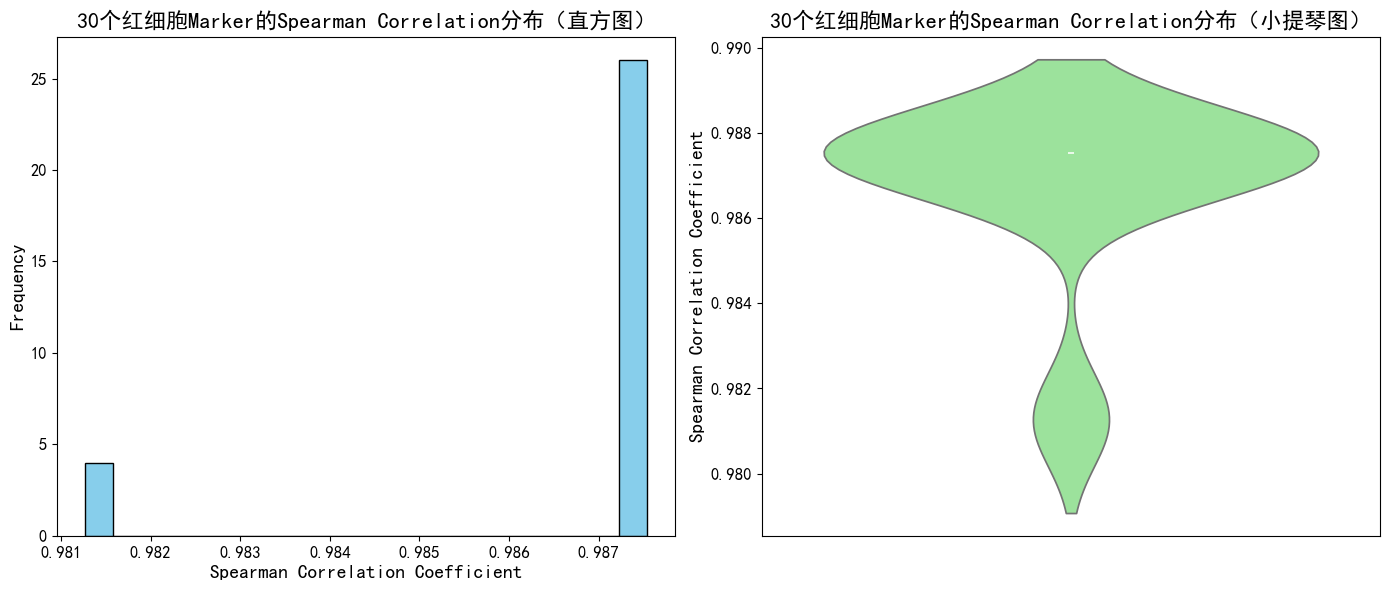

In [73]:
plt.figure(figsize=(14, 6))

# 左侧子图：直方图
plt.subplot(1, 2, 1)
plt.hist(rbc_30_markers['Correlation'], bins=20, color='skyblue', edgecolor='black')
plt.title('30个红细胞Marker的Spearman Correlation分布（直方图）', fontsize=16)
plt.xlabel('Spearman Correlation Coefficient', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.grid(True)

# 右侧子图：小提琴图
plt.subplot(1, 2, 2)
sns.violinplot(y=rbc_30_markers['Correlation'], color='lightgreen')
plt.title('30个红细胞Marker的Spearman Correlation分布（小提琴图）', fontsize=16)
plt.ylabel('Spearman Correlation Coefficient', fontsize=14)
plt.tick_params(axis='x', bottom=False, top=False, labelbottom=False)
plt.yticks(fontsize=12)
#plt.grid(True)

# 调整子图之间的间距
plt.tight_layout()
plt.savefig(r'F:\工作\流程开发\血浆样本污染\文章\代码整理\figures\fig5\5e.5-30个红细胞Marker的Spearman Correlation分布.pdf', bbox_inches='tight')


Figure 5g: RBC_spearman_10%_30markers_prot_abundance_distribution_mean20250211.pdf

In [93]:
pg_matrix_np23_21 = pd.read_csv(r"F:\工作\流程开发\血浆样本污染\MarkerFinding\data_ghh\02溶血污染\RBC_PRP_different_ratio_evaluation_NP23_21samples20241118.pg_matrix.tsv",sep = "\t")
pg_matrix_np23_21 = process_and_modify_platelet(pg_matrix_np23_21)
Erythrocytes_cor = pd.read_csv(r'/mnt/f/工作/流程开发/血浆样本污染/MarkerFinding/建立血小板等污染相关的算法-Task2_20241216/Erythrocytes_cor.csv',index_col=0)

tmp = pd.DataFrame(pg_matrix_np23_21.iloc[:, 5:].sum(axis=1))
tmp.columns = ['total_abundance']
tmp['Protein.Group'] = pg_matrix_np23_21['Protein.Group']
tmp = pd.merge(Erythrocytes_cor,tmp,left_index=True,right_on='Protein.Group',how="inner")

tmp = tmp[tmp['np23_spearman_p_value']<0.05]

spearman_10_marker = tmp.sort_values(by = 'np23_spearman_corr',ascending=False).head(int(len(tmp)*0.1)).sort_values(by = 'total_abundance',ascending=False).head(30)


In [94]:
pg_matrix_np23_132 = pd.read_csv(r"F:\工作\流程开发\血浆样本污染\MarkerFinding\建立血小板等污染相关的算法-Task5_20250120\RBC_serial_dilution20250119new\DIANN181_OmniProtV2_RBCs_con_index_24minDIA_report.pg_matrix.tsv",sep = "\t")
pg_matrix_np23_132 = process_and_modify_platelet(pg_matrix_np23_132)

pg_matrix_np23_132_spearman_markers = pg_matrix_np23_132[pg_matrix_np23_132.index.isin(spearman_10_marker.index)].iloc[:, 5:].T
pg_matrix_np23_132_spearman_markers['Sample_ID'] = pg_matrix_np23_132_spearman_markers.index.astype(str)

sampleinfo_132 = pd.read_excel(r"F:\工作\流程开发\血浆样本污染\MarkerFinding\建立血小板等污染相关的算法-Task5_20250120\RBC_serial_dilution\OmniProtV2_RBC_index_sample_information20250117-0906.xlsx")
sampleinfo_132['Sample_ID'] = sampleinfo_132['Sample_ID'].astype(str).str.zfill(3)
## 去除P00样本
sampleinfo_132 = sampleinfo_132[sampleinfo_132['Concentration_ID'] != 'P00']
pg_matrix_np23_132_spearman_markers = pg_matrix_np23_132_spearman_markers[pg_matrix_np23_132_spearman_markers.index.isin(sampleinfo_132['Sample_ID'])]

tmp = sampleinfo_132[sampleinfo_132['Patient_ID'].isin(['Patient1-3','Patient4-6'])]


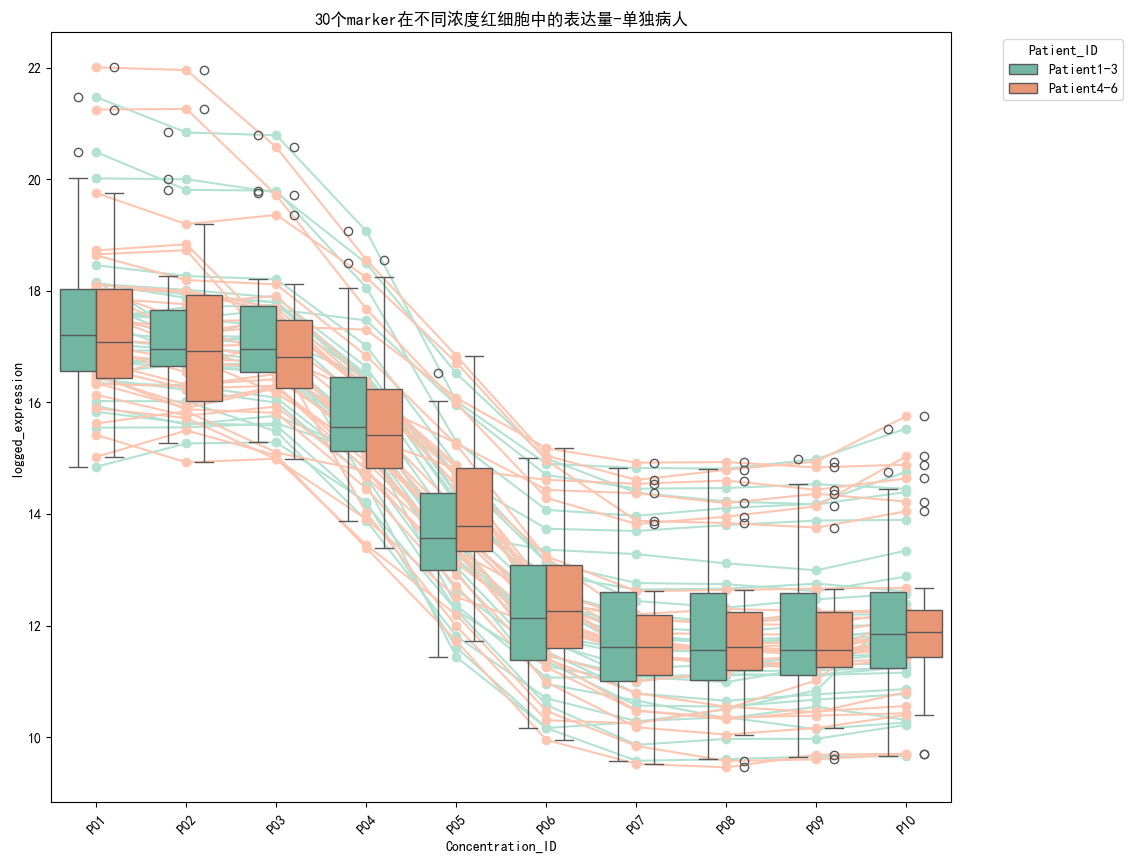

In [95]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    try:
        c = mcolors.to_rgba(color)
    except ValueError:
        return color
    return tuple(min(1, max(0, c[i] + (1 - c[i]) * amount)) for i in range(3)) + (c[3],)

def plot_boxplot_with_median_lines(pg_matrix, sampleinfo, title):
    # 合并数据框
    merged_df = pd.merge(pg_matrix, sampleinfo[['Sample_ID', 'Concentration_ID', 'Patient_ID']], on='Sample_ID')

    # 选择数值列
    numeric_cols = merged_df.select_dtypes(include=[np.number]).columns

    # 按 Concentration_ID 和 Patient_ID 分组并计算平均值
    grouped_avg = merged_df.groupby(['Concentration_ID', 'Patient_ID'])[numeric_cols].mean().reset_index()

    # 将数据转换为长格式
    grouped_avg_long = grouped_avg.melt(id_vars=['Concentration_ID', 'Patient_ID'], var_name='Protein', value_name='Value')

    # 绘制 boxplot
    plt.figure(figsize=(15, 10))

    # 使用 hue 参数按 Patient_ID 分组
    
    # 计算每个 Protein 在不同 Concentration_ID 之间的中位数
    median_df = grouped_avg_long.groupby(['Patient_ID', 'Protein', 'Concentration_ID'])['Value'].median().unstack()

    # 获取唯一的 Patient_ID 列表
    patient_ids = median_df.index.get_level_values('Patient_ID').unique()

    # 创建一个颜色映射
    color_map = {patient: lighten_color(color, 0.5) for patient, color in zip(patient_ids, plt.cm.Set2.colors)}

    # 连接相同 Patient_ID 和 Protein 的中位数
    for (patient, protein), group in median_df.iterrows():
        plt.plot(group.index, group.values, marker='o', linestyle='-', color=color_map[patient])
    sns.boxplot(x='Concentration_ID', y='Value', hue='Patient_ID', data=grouped_avg_long, palette='Set2')

    plt.xticks(rotation=45)
    plt.xlabel('Concentration_ID')
    plt.ylabel('logged_expression')
    plt.title('30个marker在不同浓度红细胞中的表达量-单独病人')
    
    # 调整边距以确保图例完整显示
    plt.subplots_adjust(right=0.75, left=0.15)
    
    plt.legend(title='Patient_ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig(f'{title}.pdf', format='pdf')
    plt.show()

# 示例调用
pg_matrix_np23_132_spearman_10_markers_markers_logged = np.log(pg_matrix_np23_132_spearman_markers[pg_matrix_np23_132_spearman_markers.index.isin(tmp['Sample_ID'])].astype(float) + 1e-6)
pg_matrix_np23_132_spearman_10_markers_markers_logged['Sample_ID'] = pg_matrix_np23_132_spearman_10_markers_markers_logged.index.astype(str)
plot_boxplot_with_median_lines(pg_matrix_np23_132_spearman_10_markers_markers_logged, sampleinfo_132, r'F:\工作\流程开发\血浆样本污染\文章\代码整理\figures\fig5\5g.RBC_spearman_10%_30markers_prot_abundance_distribution_mean20250211')
# ## na填充低表达量
# ## 红细胞基本没有低表达量
# pg_matrix_np23_132_spearman_10_markers_markers_logged.iloc[:, :-1] = pg_matrix_np23_132_spearman_10_markers_markers_logged.iloc[:, :-1].where(pg_matrix_np23_132_spearman_markers.iloc[:, :-1] >= np.log(10000), np.nan)

# plot_boxplot_with_median_lines(pg_matrix_np23_132_spearman_10_markers_markers_logged, sampleinfo_132, 'RBC_spearman_10%_30markers_prot_abundance_distribution_mean20250211_deleteLowIntensity')

Figure 5h: RBC_spearman_10%_30markers_con_index_spearman_all20250218.pdf

In [98]:
def containmination_index(marker,pro):
    marker_pro = pro[pro.index.isin(marker)]
    #print(marker_pro.shape)

    marker_exp = marker_pro.sum(axis=0)
    total_exp = pro.sum(axis=0)
    res = pd.DataFrame(marker_exp/total_exp)
    res.columns = ['containmination_index']
    res['Sample_ID'] = res.index
    return res

spearman10_comtainmination_index = containmination_index(spearman_10_marker.index,pg_matrix_np23_132.iloc[:,5:])

tmp = pd.merge(sampleinfo_132,spearman10_comtainmination_index,on = 'Sample_ID' )
tmp['RBC_absolute amount (calculation)'] = tmp['RBC_absolute amount (calculation)'].astype(float)
tmp['log10_RBC_count'] = np.log10(tmp['RBC_absolute amount (calculation)'])

tmp = tmp[tmp['Patient_ID'].isin(['Patient1-3','Patient4-6'])]

print(plot_correlations_to_pdf(tmp, 'log10_RBC_count', 'containmination_index', 
                        f'Correlations between log10(RBC count) and containmination index calculated by 10% 30 spearman markers', 
                        fr'F:\工作\流程开发\血浆样本污染\文章\代码整理\figures\fig5\5h.1.RBC_spearman_10%_30markers_con_index_spearman_all20250220.pdf'))

     Method  Correlation       P-value
0   Pearson     0.771156  5.655693e-13
1  Spearman     0.859695  1.446966e-18
2    Spline     0.948676           NaN


Figure 5h:RBC_spearman_10%_30markers_con_index_spearman_partial20250218.pdf

In [99]:
tmp = tmp[tmp['log10_RBC_count'] >= 6]
print(plot_correlations_to_pdf(tmp, 'log10_RBC_count', 'containmination_index', 
                        f'Correlations between log10(RBC count) and containmination index calculated by 10% 30 spearman markers', 
                        fr'F:\工作\流程开发\血浆样本污染\文章\代码整理\figures\fig5\5h.2.RBC_spearman_10%_30markers_con_index_spearman_partial20250218.pdf'))

     Method  Correlation       P-value
0   Pearson     0.942928  5.530435e-12
1  Spearman     0.864294  5.217050e-08
2    Spline     0.939516           NaN


Figure 7d: Platelets_30markers_200patients_contamination_index_distribution20250307.pdf

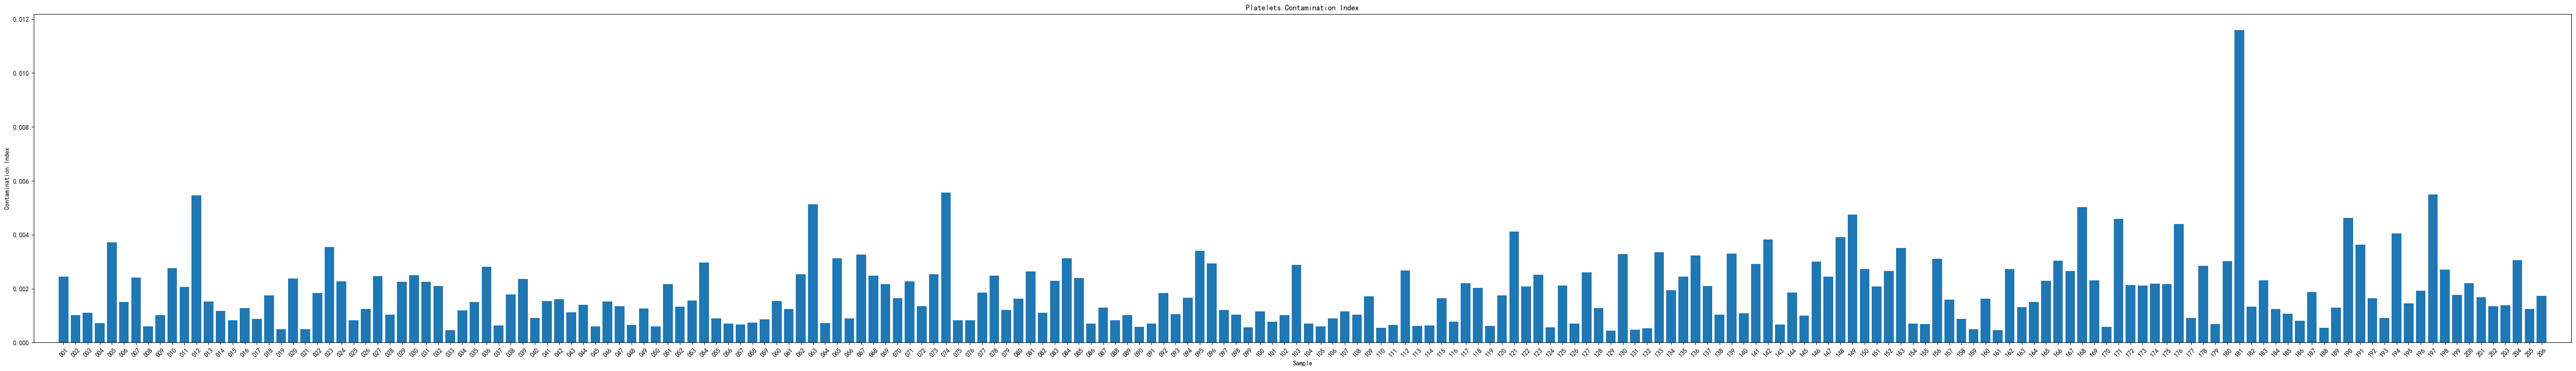

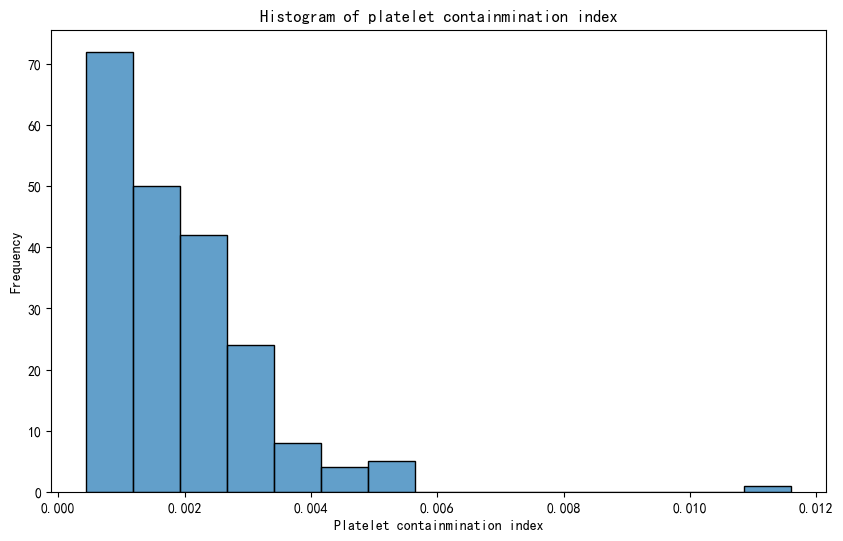

In [108]:
pg_matrix_lung = pd.read_csv(r'F:\工作\个性化\20241112-OmniProt-肺癌早筛-机器学习\data\WAN20241016gaohh_OmniprotV2_lung_cohort_B1_B7_DIANN181_report.pg_matrix.tsv',sep = "\t")
pg_matrix_lung['Protein.Group'] = pg_matrix_lung['Protein.Group'] + "_" + pg_matrix_lung['Genes']
pg_matrix_lung.index = pg_matrix_lung['Protein.Group']

tmp = pg_matrix_lung.iloc[:,5:]
newcol = []
for col in tmp.columns:
            last_element = col.split('\\')[-1]
            last_element = last_element.split(".")[0]
            match = re.search(r'B\w+', last_element)
            last_element = match.group()
            #last_element = col.split('_')[-1]
            newcol.append(last_element)
tmp.columns = newcol

col_names = tmp.columns.tolist()
new_col_names = [str(i).zfill(3) for i in range(1, len(col_names)+1)]
tmp.columns = new_col_names

platelet_omniprot_marker = pd.read_csv(r"F:\工作\流程开发\血浆样本污染\MarkerFinding\建立血小板等污染相关的算法-Task5_20250120\results\markers\spearman_10%.csv")['Protein']
with PdfPages(r'F:\工作\流程开发\血浆样本污染\文章\代码整理\figures\fig7\7d.Platelets_30markers_200patients_contamination_index_distribution20250307.pdf') as pdf:
    ## 折线图
        plt.figure(figsize=(55, 8))
        data = containmination_index(platelet_omniprot_marker, tmp)
        plt.bar(data['Sample_ID'], data['containmination_index'])
        plt.title("Platelets Contamination Index")
        plt.xlabel("Sample")
        plt.ylabel("Contamination Index")

        # 添加图例
        plt.xticks(rotation=45)
        plt.margins(x=0.01)
        plt.tight_layout()  # 防止标签被截断

        # 保存当前图到PDF
        pdf.savefig()
 
        ## 直方图分布
        tmp2 = containmination_index(platelet_omniprot_marker,tmp)
        plt.figure(figsize=(10, 6))
        ax = sns.histplot(tmp2['containmination_index'], bins=15, edgecolor='black', alpha=0.7, kde=False)

        # # 在每个柱子上添加数字
        # for p in ax.patches:
        #     height = p.get_height()
        #     if height != 0:
        #         ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
        #                     ha='center', va='bottom', fontsize=10, color='black')

        plt.title('Histogram of platelet containmination index')
        plt.xlabel('Platelet containmination index')
        plt.ylabel('Frequency')
        pdf.savefig()

Figure 7e: RBC_30markers_200patients_contamination_index_distribution20250307.pdf

In [106]:
rbc_omniprot_marker = spearman_10_marker.index

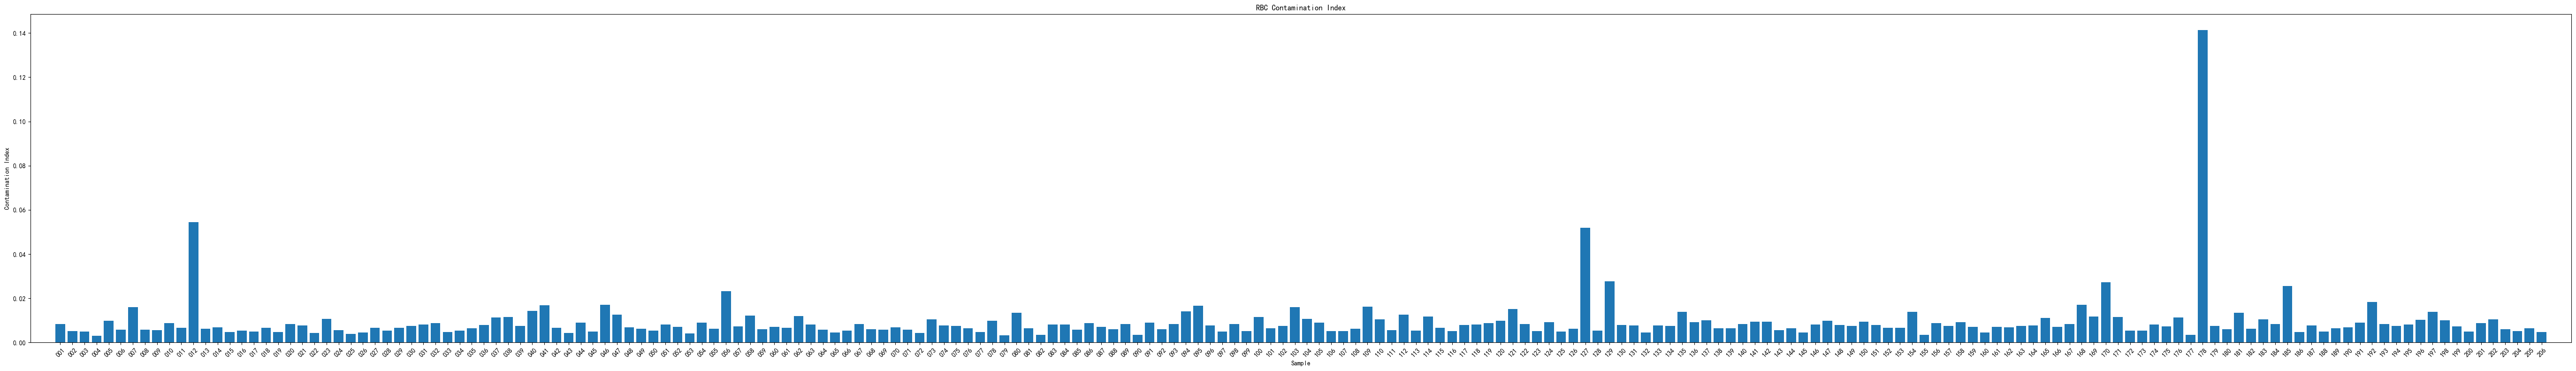

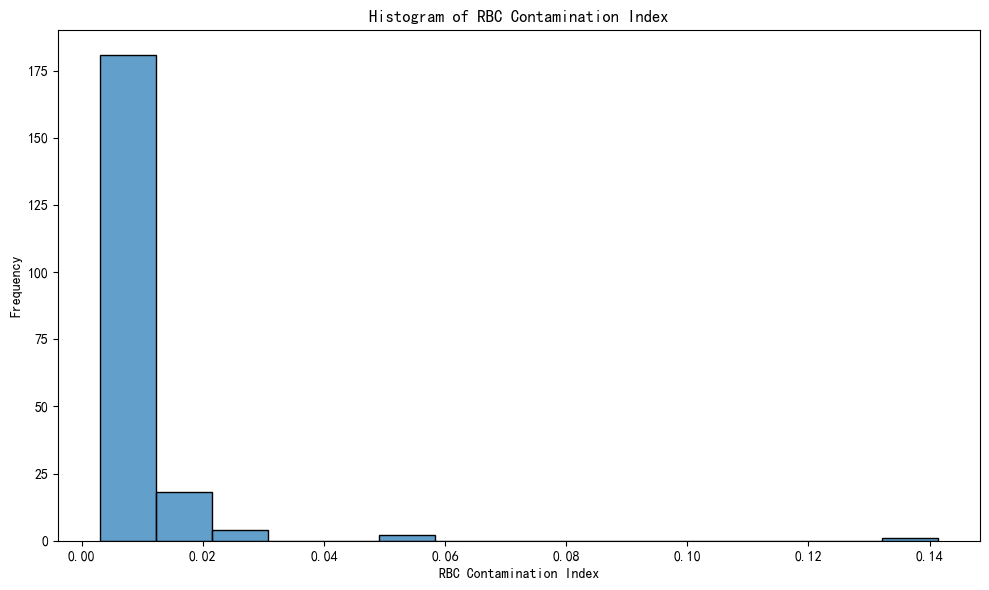

In [109]:
with PdfPages(r'F:\工作\流程开发\血浆样本污染\文章\代码整理\figures\fig7\7e.RBC_30markers_200patients_contamination_index_distribution20250307.pdf') as pdf:
    ## 柱状图
    plt.figure(figsize=(55, 8))
    data = containmination_index(rbc_omniprot_marker, tmp)
    plt.bar(data['Sample_ID'], data['containmination_index'])
    plt.title("RBC Contamination Index")
    plt.xlabel("Sample")
    plt.ylabel("Contamination Index")

    # 添加图例
    plt.xticks(rotation=45)
    plt.margins(x=0.01)
    plt.tight_layout()  # 防止标签被截断

    # 保存当前图到PDF
    pdf.savefig()

    ## 直方图分布
    tmp2 = containmination_index(rbc_omniprot_marker, tmp)
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(tmp2['containmination_index'], bins=15, edgecolor='black', alpha=0.7, kde=False)

    # # 在每个柱子上添加数字
    # for p in ax.patches:
    #     height = p.get_height()
    #     if height != 0:
    #         ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
    #                     ha='center', va='bottom', fontsize=10, color='black')

    plt.title('Histogram of RBC Contamination Index')
    plt.xlabel('RBC Contamination Index')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    pdf.savefig()

Figure 7f: Coagulation_3markers_200patients_contamination_index_distribution20250307.pdf

In [110]:
coag_omniprot_marker = ["P02679_FGG", "P02675_FGB", "P02671_FGA"]

In [111]:
def containmination_index(marker,pro,reverse = False):
    marker_pro = pro[pro.index.isin(marker)]
    #print(marker_pro.shape)

    marker_exp = marker_pro.sum(axis=0)
    total_exp = pro.sum(axis=0)
    if reverse == False:
        res = pd.DataFrame(marker_exp/total_exp)
    else:
        res = pd.DataFrame(total_exp/marker_exp)
    res.columns = ['containmination_index']
    res['Sample_ID'] = res.index
    return res

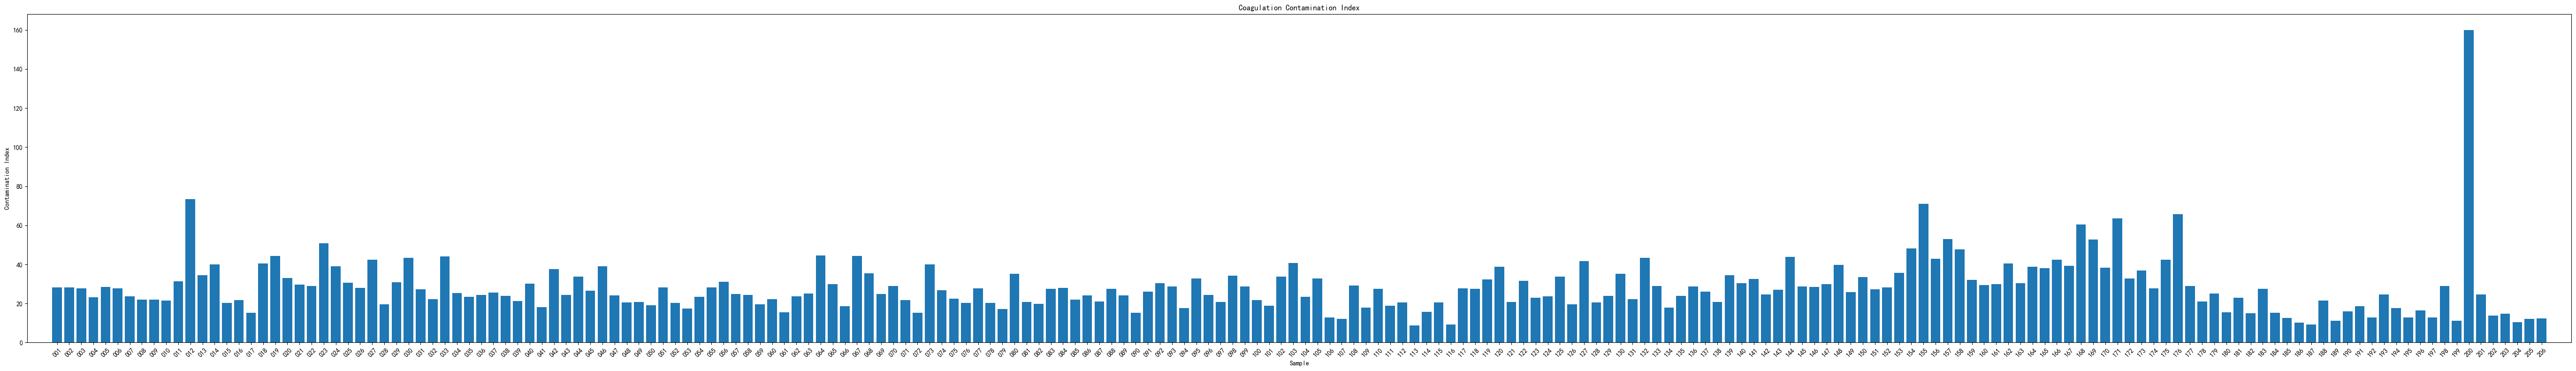

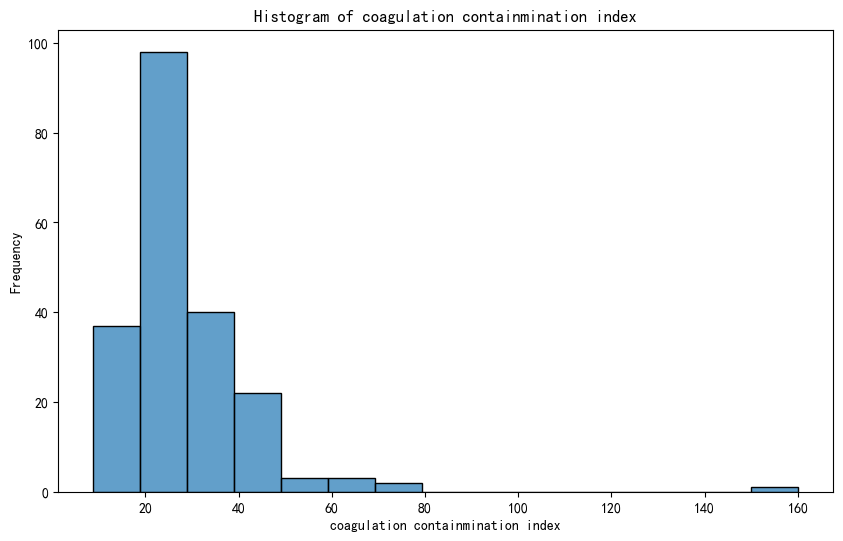

In [112]:
with PdfPages(r'F:\工作\流程开发\血浆样本污染\文章\代码整理\figures\fig7\7f.Coagulation_3markers_200patients_contamination_index_distribution20250307.pdf') as pdf:
    ## 折线图
        plt.figure(figsize=(55, 8))
        data =  containmination_index(coag_omniprot_marker,tmp,reverse = True)
        plt.bar(data['Sample_ID'], data['containmination_index'])
        plt.title("Coagulation Contamination Index")
        plt.xlabel("Sample")
        plt.ylabel("Contamination Index")

        # 添加图例
        plt.xticks(rotation=45)
        plt.margins(x=0.01)
        plt.tight_layout()  # 防止标签被截断

        # 保存当前图到PDF
        pdf.savefig()
 
        ## 直方图分布
        tmp2 = containmination_index(coag_omniprot_marker,tmp,reverse = True)
        plt.figure(figsize=(10, 6))
        ax = sns.histplot(tmp2['containmination_index'], bins=15, edgecolor='black', alpha=0.7, kde=False)

        # # 在每个柱子上添加数字
        # for p in ax.patches:
        #     height = p.get_height()
        #     if height != 0:
        #         ax.annotate(f'coag_omniprot_markerheight}', (p.get_x() + p.get_width() / 2., height),
        #                     ha='center', va='bottom', fontsize=10, color='black')

        plt.title('Histogram of coagulation containmination index')
        plt.xlabel('coagulation containmination index')
        plt.ylabel('Frequency')
        pdf.savefig()

Figure 7g: ml_stat_heatmap_20250307.pdf

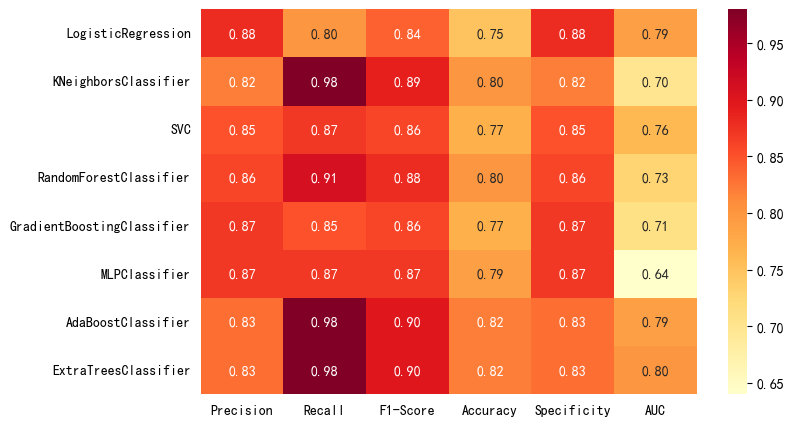

In [113]:
ml_result = pd.read_csv(r'F:\工作\个性化\20241112-OmniProt-肺癌早筛-机器学习\add_feature\20250107ASS\seed_139\result\Params_table.csv')
ml_result.index = ml_result['Classifier']
ml_result.index.name = None
ml_result = ml_result[['Precision','Recall', 'F1-Score', 'Accuracy',  'Specificity','AUC']]
ml_result['Accuracy'] = ml_result['Accuracy']/100

plt.figure(figsize=(8, 5))
# 将数值四舍五入到小数点后两位
ml_result_rounded = ml_result.round(2)

ax = sns.heatmap(ml_result_rounded, annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': ''})

# 去掉刻度线
ax.tick_params(left=False, bottom=False)

plt.savefig(r"F:\工作\流程开发\血浆样本污染\文章\代码整理\figures\fig7\7g.ml_stat_heatmap_20250307.pdf", format='pdf', bbox_inches='tight')
plt.show()


Figure 7h: omiprot_lung_20250107\feature_importance.pdf

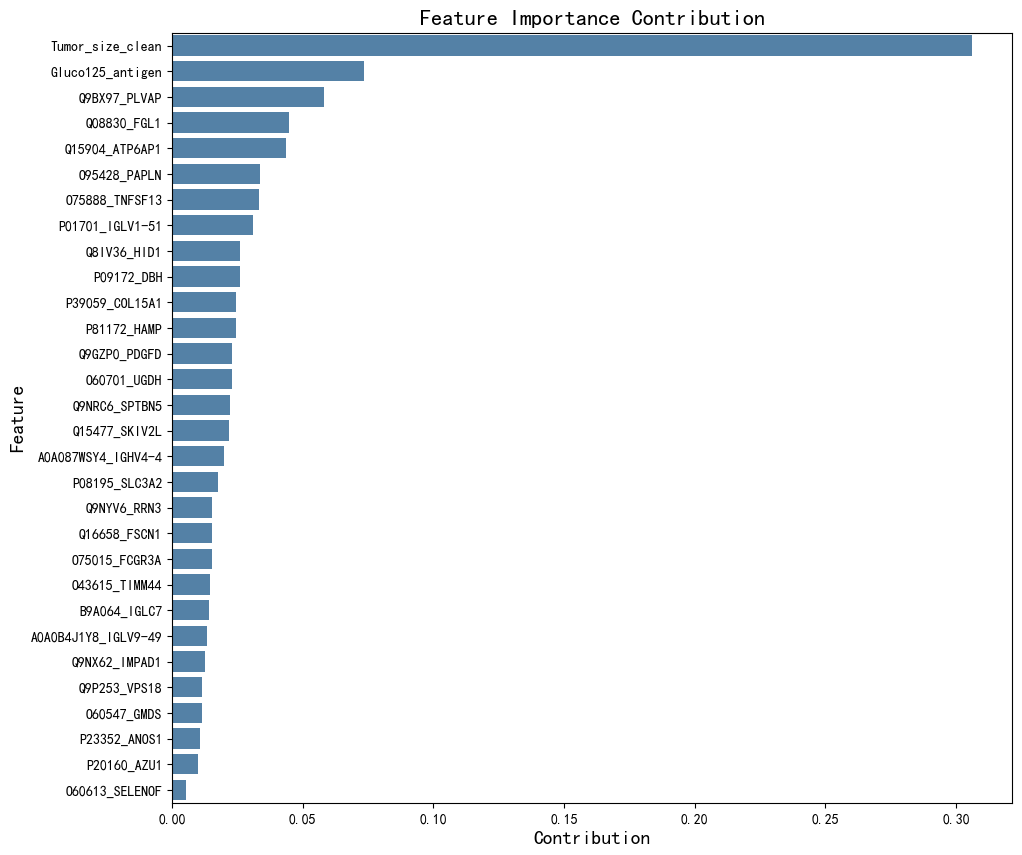

In [114]:
file_path = r'F:\工作\个性化\20241112-OmniProt-肺癌早筛-机器学习\add_feature\20250107ASS\seed_139\feature_importances.csv'
df = pd.read_csv(file_path, index_col=0)

# 计算每一列的平均值
mean_values = df.mean()

# 重置索引以便绘制条形图
mean_values = mean_values.reset_index()
mean_values.columns = ['Feature', 'Contribution']

# 按照Contribution排序
mean_values = mean_values.sort_values(by='Contribution', ascending=False)

# 设置图形大小
plt.figure(figsize=(12, 10))

# 使用seaborn绘制水平条形图
sns.barplot(data=mean_values, x='Contribution', y='Feature', color="steelblue")

# 设置标题和轴标签
plt.title('Feature Importance Contribution',fontsize=16)
plt.xlabel('Contribution',fontsize=14)
plt.ylabel('Feature',fontsize=14)

# 调整子图参数，增加左边的边距
plt.subplots_adjust(left=0.2)  # 你可以根据需要调整这个值

# 保存图形
plt.savefig(r'F:\工作\流程开发\血浆样本污染\文章\代码整理\figures\fig7\7h.feature_importance.pdf', format='pdf')

# 显示图形
plt.show()

In [101]:
## 查找
import os

def find_files(root_path, substring):
    matches = []
    for dirpath, dirnames, filenames in os.walk(root_path):
        for filename in filenames:
            if substring in filename:
                matches.append(os.path.join(dirpath, filename))
    return matches

filename = "Platelets_30markers_200patients_contamination_index_distribution20250307.pdf"
found_files = find_files(r"F:\工作\流程开发\血浆样本污染\MarkerFinding", filename)
#found_files = find_files(r"F:\工作\流程开发\血浆样本污染\MarkerFinding", filename)
for file in found_files:
    print(file)

F:\工作\流程开发\血浆样本污染\MarkerFinding\Task8_20250225\result_20250307\Platelets_30markers_200patients_contamination_index_distribution20250307.pdf
F:\工作\流程开发\血浆样本污染\MarkerFinding\结果汇总(20250210往后）\20250225_reuslts\result_20250307\Platelets_30markers_200patients_contamination_index_distribution20250307.pdf
